# Sentiment Analysis of "The Lion King (2019)" movie reviews

## Web Scraping

In [21]:
import requests
import time
import pandas as pd
import json

###### Connect to rottentomatoes.com and collect user reviews for movie Lion king(2019). Each session retrives 10 reviews. So run 300 iterations and have time gap of 5 seconds between each iteration. Save the result of each session as json file in 'reviews' folder. After the run completes we have 300 json files.

In [22]:
headers = {
'Referer': 'https://www.rottentomatoes.com/m/the_lion_king_2019/reviews?type=user',
'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36',
'X-Requested-With': 'XMLHttpRequest',
}


url = 'https://www.rottentomatoes.com/napi/movie/9057c2cf-7cab-317f-876f-e50b245ca76e/reviews/user'
payload = {
'direction': 'next',
'endCursor': '',
'startCursor': '',
}


s = requests.Session()
i=1
while i<=3:
    r = s.get(url, headers=headers, params=payload)
    data = r.json()
    with open('./reviews/review'+str(i)+'.json', 'w') as f:
        json.dump(data['reviews'], f)
    payload['endCursor'] = data['pageInfo']['endCursor']
    payload['startCursor'] = data['pageInfo']['startCursor']
    i+=1
    time.sleep(5)

## Combine json files to csv

In [23]:
import json
import os
from glob import glob
import pandas as pd

In [25]:
pattern = os.path.join('C:\\Users\\Z003RJMK\\Desktop\\Eureka_Learn\\Simplilearn\\2_DS_Using_Python\\Session9\\NLP with Web Scrapping\\reviews', '*.json')

In [26]:
# This code combines reads all json files and writes the required features to a dataframe
data = pd.DataFrame()
for file_name in glob(pattern):
    with open(file_name) as f:
        json_data = json.load(f)
        df = pd.DataFrame.from_dict(json_data, orient='columns')
        user_data = pd.DataFrame()
        for review in json_data:
            user = pd.DataFrame([review['user']])
            user_data = user_data.append(user, ignore_index=True)
        df = pd.concat([df,user_data], axis=1)
        data = data.append(df, ignore_index=True)

In [27]:
data.columns

Index(['rating', 'review', 'displayName', 'displayImageUrl', 'isVerified',
       'isSuperReviewer', 'hasSpoilers', 'hasProfanity', 'createDate',
       'updateDate', 'user', 'score', 'timeFromCreation', 'userId', 'realm',
       'displayName', 'accountLink'],
      dtype='object')

In [28]:
data.head()

,rating,review,displayName,displayImageUrl,isVerified,isSuperReviewer,hasSpoilers,hasProfanity,createDate,updateDate,user,score,timeFromCreation,userId,realm,displayName,accountLink
0,STAR_1,Completely ruined. I feel robbed of my childhood.,Andrew B,https://graph.facebook.com/v3.3/581671457/picture,False,False,False,False,2021-02-06T18:17:14.650Z,2021-02-06T18:17:14.590Z,"{'userId': '914791383', 'realm': 'RT', 'displa...",1.0,10h ago,914791383,RT,Andrew B,/user/id/914791383
1,STAR_4,Wonderful to see this Disney classic brought t...,John B,None,False,False,False,False,2021-02-01T14:22:36.165Z,2021-02-01T14:22:36.322Z,"{'userId': '786562507', 'realm': 'RT', 'displa...",4.0,6d ago,786562507,RT,John B,/user/id/786562507
2,STAR_1_5,"only saving grace is nostalgia, ultimately fal...",None,None,False,False,False,False,2021-02-01T01:32:22.080Z,2021-02-01T01:32:22.142Z,{'userId': '86c79363-2fe8-4910-8ab2-1ec57d6793...,1.5,6d ago,86c79363-2fe8-4910-8ab2-1ec57d679326,Flixster,None,None
3,STAR_0_5,There's no doubt that this is technical achiev...,Ben L,None,False,False,False,False,2021-01-28T17:35:03.389Z,2021-01-28T17:35:03.376Z,"{'userId': '978458581', 'realm': 'RT', 'displa...",0.5,"Jan 28, 2021",978458581,RT,Ben L,/user/id/978458581
4,STAR_1,A disgusting and insulting imitation of the be...,Krzysztof,None,False,False,False,True,2021-01-27T18:36:49.856Z,2021-01-27T18:40:33.442Z,"{'userId': '978992359', 'realm': 'RT', 'displa...",1.0,"Jan 27, 2021",978992359,RT,Krzysztof,/user/id/978992359


In [8]:
data.drop('user', axis=1, inplace=True)

In [29]:
data.shape

(30, 17)

In [21]:
# write the collected review data to a csv file, that can be loaded later for training
pd.DataFrame(data).to_csv("scrapped_data.csv", index = False)

# Data PreProcessing

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import spacy
nlp = spacy.load("en_core_web_sm")
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, concatenate, Flatten, Input
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from wordcloud import WordCloud

Using TensorFlow backend.


In [22]:
# read data from csv
train_data = pd.read_csv("scrapped_data.csv", sep=',', header=0, na_values='unknown')

In [23]:
train_data.head()

,createDate,displayImageUrl,displayName,hasProfanity,hasSpoilers,isSuperReviewer,isVerified,rating,review,score,timeFromCreation,updateDate,accountLink,displayName.1,realm,userId
0,2019-08-18T13:29:32.874Z,https://graph.facebook.com/v3.3/6212197/picture,Scott W,False,False,False,False,STAR_3,"Unlike some other Disney remakes, this one is ...",3.0,16m ago,2019-08-18T13:29:32.874Z,/user/id/798014537,Scott W,RT,798014537
1,2019-08-18T13:23:58.374Z,NaN,William S,False,False,False,True,STAR_5,Loved the movie!! The music was and is great!!...,5.0,22m ago,2019-08-18T13:23:58.374Z,NaN,William S,Fandango,c64b8b43-5e68-41be-b3ec-89b41ec767e4
2,2019-08-18T13:22:09.835Z,NaN,Kristy,False,False,False,True,STAR_4_5,It was a well made movie. I,4.5,24m ago,2019-08-18T13:22:09.835Z,NaN,Kristy,Fandango,685f2a19-f581-43a6-bdbd-6db9e12a14fc
3,2019-08-18T12:45:33.930Z,NaN,Kelli,False,False,False,False,STAR_1,They took all of the puns out!! They took the ...,1.0,1h ago,2019-08-18T12:45:33.930Z,NaN,Kelli,Fandango,db558a10-7aa3-4980-919c-2e786dbf619d
4,2019-08-18T12:41:58.616Z,NaN,Ashley N,False,False,False,True,STAR_5,Loved it! I am a huge fan of the original so I...,5.0,1h ago,2019-08-18T12:41:58.616Z,NaN,Ashley N,Fandango,601D3E10-C29D-426E-AF31-E04DF16BD3F2


In [24]:
train_data.dtypes

createDate           object
displayImageUrl      object
displayName          object
hasProfanity           bool
hasSpoilers            bool
isSuperReviewer        bool
isVerified             bool
rating               object
review               object
score               float64
timeFromCreation     object
updateDate           object
accountLink          object
displayName.1        object
realm                object
userId               object
dtype: object

In [25]:
train_data.describe(include='all')

,createDate,displayImageUrl,displayName,hasProfanity,hasSpoilers,isSuperReviewer,isVerified,rating,review,score,timeFromCreation,updateDate,accountLink,displayName.1,realm,userId
count,3000,223,2861,3000,3000,3000,3000,3000,3000,3000.000000,3000,3000,611,2861,3000,3000
unique,3000,223,2464,2,2,2,2,10,2995,NaN,44,3000,611,2464,2,3000
top,2019-08-05T14:12:25.623Z,https://graph.facebook.com/v3.3/59200855/picture,Google,False,False,False,True,STAR_5,Great movie for all ages,NaN,"Aug 05, 2019",2019-08-05T14:12:25.623Z,/user/id/978104240,Google,Fandango,a53ddbda-97b4-4cb6-ba0a-d57c7005ae1f
freq,1,1,14,2968,2998,2999,2165,1370,2,NaN,318,1,1,14,2389,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.919833,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.316840,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# read createDate column and fetch only the day
review_day = []
for user_time in train_data['createDate']:
    review_day.append(datetime.datetime.strptime(user_time, '%Y-%m-%dT%H:%M:%S.%fZ').day)
len(review_day)

NameError: name 'datetime' is not defined

In [ ]:
# create a new column day
train_data['day'] = review_day

In [ ]:
# calculate how many words each review has 
word_count = []
for review in train_data['review']:
    word_count.append(len(review.split()))
len(word_count)

In [ ]:
# add word count of each review as another column to train data
train_data['word_count'] = word_count

In [ ]:
# calculate target 'sensitivity' from 'score' field
train_data['sensitivity'] = train_data['score'] <= 3
train_data['sensitivity'] = train_data['sensitivity'].astype('int')
train_data['sensitivity'] = train_data['sensitivity'].astype('category')

In [11]:
# remove columns that are not required
del train_data['displayImageUrl']
del train_data['displayName']
del train_data['displayName.1']
del train_data['rating']
del train_data['timeFromCreation']
del train_data['accountLink']
del train_data['updateDate']
del train_data['userId']
del train_data['score']
del train_data['createDate']

In [12]:
train_data.head()

,hasProfanity,hasSpoilers,isSuperReviewer,isVerified,review,realm,day,word_count,sensitivity
0,False,False,False,False,"Unlike some other Disney remakes, this one is ...",RT,18,61,1
1,False,False,False,True,Loved the movie!! The music was and is great!!...,Fandango,18,14,0
2,False,False,False,True,It was a well made movie. I,Fandango,18,7,0
3,False,False,False,False,They took all of the puns out!! They took the ...,Fandango,18,36,1
4,False,False,False,True,Loved it! I am a huge fan of the original so I...,Fandango,18,28,0


# Exploratory data analysis

#### (Sensitivity) w.r.t (Number of words in each review)

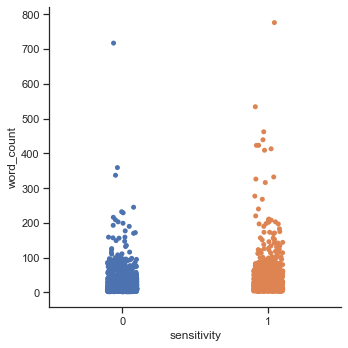

In [13]:
sns.set(style="ticks", color_codes=True)
sns.catplot(x="sensitivity", y="word_count", data=train_data);

# The graph shows both positve and negative reviews has not less but almost equal number of word counts

#### Checking all boolean features

In [14]:
train_data.hasProfanity.value_counts()

False    2968
True       32
Name: hasProfanity, dtype: int64

In [15]:
train_data.hasSpoilers.value_counts()

False    2998
True        2
Name: hasSpoilers, dtype: int64

In [16]:
train_data.isSuperReviewer.value_counts()

False    2999
True        1
Name: isSuperReviewer, dtype: int64

In [17]:
train_data.isVerified.value_counts()

True     2165
False     835
Name: isVerified, dtype: int64

In [18]:
# Remove hasSpoliers and isSuperReviewer columns as they have very less "True"
del train_data['hasSpoilers']
del train_data['isSuperReviewer']

#### (Profanity count) w.r.t (Sensitivity)

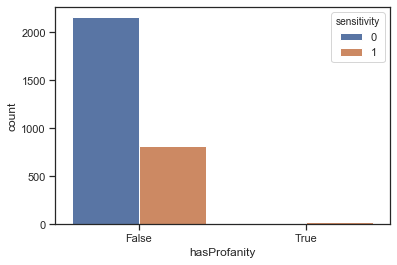

In [19]:
# Plot this graph to check if Profane language really contributes much to the positive/negative reviews
p = sns.countplot(data=train_data,
                  x = 'hasProfanity',
                  hue = 'sensitivity')

In [20]:
train_data.hasProfanity.value_counts()

False    2968
True       32
Name: hasProfanity, dtype: int64

#### (Profanity) w.r.t (number of words in each review)

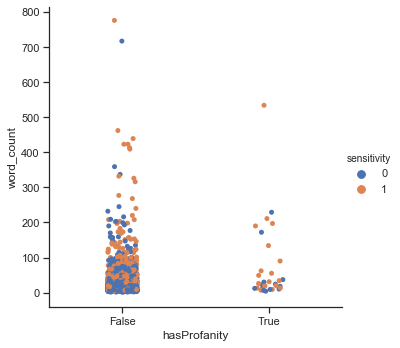

In [21]:
# Plot this graph to check if the review containing profanity is biased to negative sentiment.
sns.set(style="ticks", color_codes=True)
sns.catplot(x="hasProfanity", y="word_count", hue='sensitivity', data=train_data);

# The graph says both positve and negative reviews equally has profane language

#### (Verified users) w.r.t (Sensitivity)

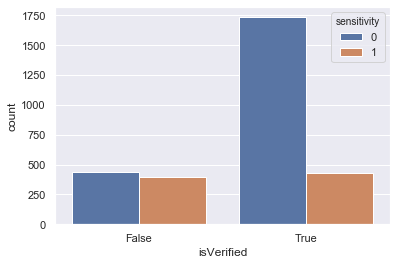

In [64]:
sns.set(rc={'figure.figsize':(6,4)})
p = sns.countplot(data=train_data,
                  x = 'isVerified',
                  hue = 'sensitivity', )

# The graph shows Verified users have given more positive reviews than negative reviews

#### (Verified user) w.r.t (number of words in each review)

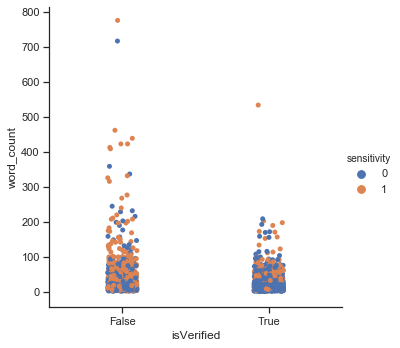

In [23]:
sns.set(style="ticks", color_codes=True)
sns.catplot(x="isVerified", y="word_count", hue='sensitivity', data=train_data);

# The graph shows non verified users are not biased to either positive/negative reviews with respect to word count

In [24]:
train_data.head()

,hasProfanity,isVerified,review,realm,day,word_count,sensitivity
0,False,False,"Unlike some other Disney remakes, this one is ...",RT,18,61,1
1,False,True,Loved the movie!! The music was and is great!!...,Fandango,18,14,0
2,False,True,It was a well made movie. I,Fandango,18,7,0
3,False,False,They took all of the puns out!! They took the ...,Fandango,18,36,1
4,False,True,Loved it! I am a huge fan of the original so I...,Fandango,18,28,0


In [25]:
train_data.dtypes

hasProfanity        bool
isVerified          bool
review            object
realm             object
day                int64
word_count         int64
sensitivity     category
dtype: object

In [26]:
# Convert realm and day to category
train_data['realm'] = train_data['realm'].astype('category')
train_data['day'] = train_data['day'].astype('category')

In [108]:
train_data.dtypes

hasProfanity        bool
isVerified          bool
review            object
realm           category
day             category
word_count         int64
sensitivity     category
dtype: object

#### (Realm) w.r.t (Sensitivity)

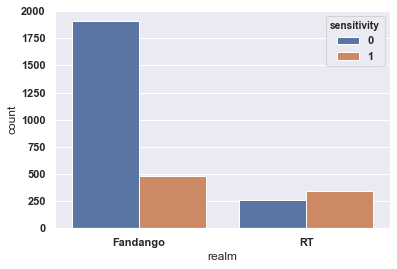

In [111]:
sns.set(rc={'figure.figsize':(6,4)})
p = sns.countplot(data=train_data,
                  x = 'realm',
                  hue = 'sensitivity', )
# From the plot we can say that Fandango users gave more positive reviews compared with rottentomatoes critics
# Also we come to know that more than hald of the official critics of rottentomatoes did not like the movie

#### (Review day) w.r.t (number of reviews in that day)

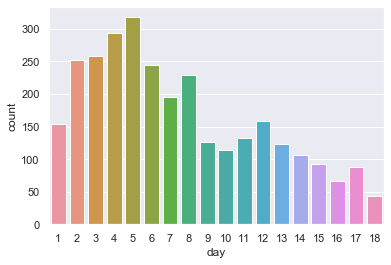

In [27]:
sns.set(rc={'figure.figsize':(6,4)})
p = sns.countplot(data=train_data,
                  x = 'day')

# Graph shows the number of reviews decreases since movie release, with more reviews registered during weekends

#### (Review day) w.r.t (number of reviews in that day) w.r.t (sensitivity)

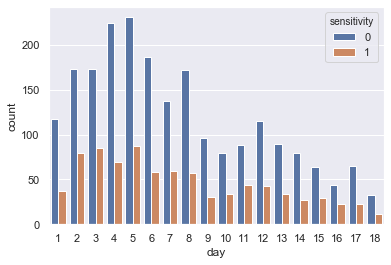

In [28]:
sns.set(rc={'figure.figsize':(6,4)})
p = sns.countplot(data=train_data,
                  x = 'day', hue = 'sensitivity')

# The graph shows review day is not biased towards positive or negative reviews

## Frequency of words

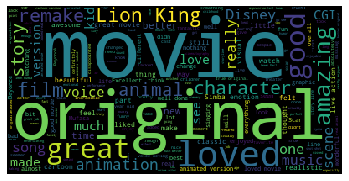

In [106]:
# This code is to get all words from all reviews and plot the importance of each word with respect to their frequency
total_review = ""
for review in train_data['review']:
    total_review = total_review + ' '+ review
wordcloud = WordCloud().generate(total_review)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Frequency of words depicted in inverted bar graph after stopwords and lemmatization

In [97]:
# This function gets total review in a paragraph and returns words without stopwords and then doing lemmatization
def process_text(reviews):
    tokenizer = regextoken('\w+')
    reg_tokens = tokenizer.tokenize(reviews)
    tokens = []
    token_lamt=[]
    tokens = [word.lower() for word in reg_tokens if word.lower() not in stopwords.words('english')]
    lmtzr = WordNetLemmatizer()
    token_lamt = [lmtzr.lemmatize(word) for word in tokens]
    return token_lamt
review_tokens = process_text(total_review)

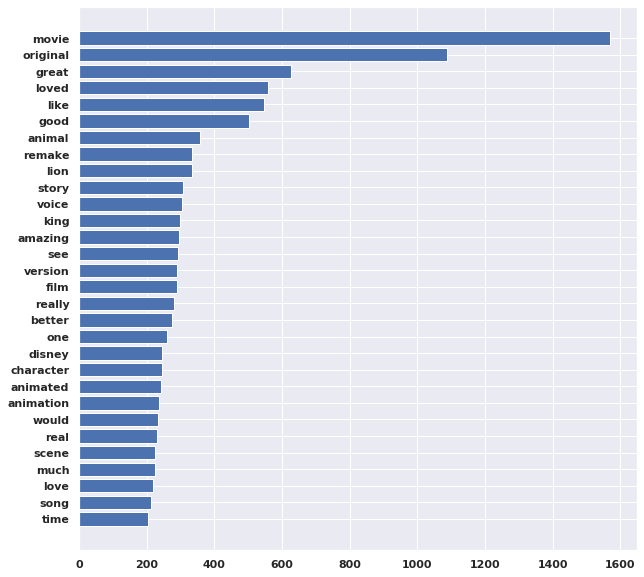

In [98]:
# This code gets the above output as input and plots frequency of every word
review_frame = pd.DataFrame({'words': review_tokens})
values, counts = np.unique(review_tokens, return_counts=True)
sorted_indices = np.argsort(-counts)
values = values[sorted_indices]
counts = counts[sorted_indices]
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 50}

plt.rc('font', **font)
fig = plt.figure(figsize=(10,10))
plt.barh(values[:30], counts[:30])
plt.gca().invert_yaxis()
plt.show()

## Analysis using Ngrams

In [59]:
# This function converts all reviews from train data dataframe to ngrams
def get_top_n_gram(corpus, n_gram, n=None):
    vec = CountVectorizer(ngram_range=(n_gram, n_gram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    common_words = words_freq[:n]
    ngram_df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
    return ngram_df

# This function plots the collected ngrams
def get_ngram_graph(df):
    sns.set(rc={'figure.figsize':(10,8)})
    top_ngrams = sns.barplot(x="count", y="ReviewText", 
             data=df.sort_values('count', ascending=False))
    top_ngrams.set(ylabel=None)

### Trigram plot of all reviews

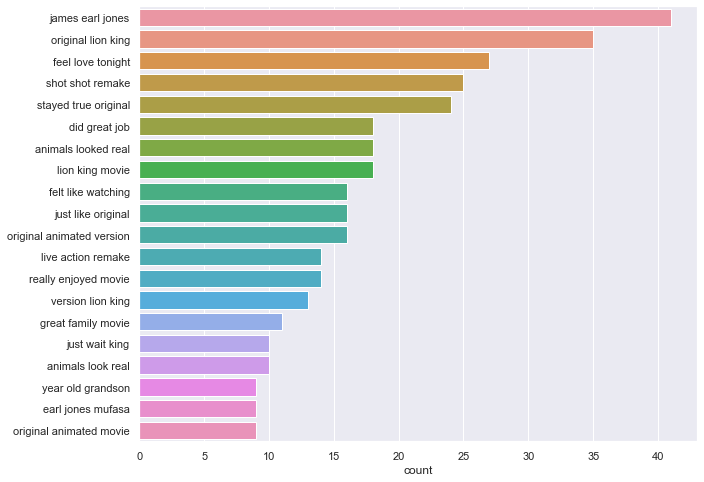

In [60]:
trigram_df = get_top_n_gram(train_data['review'], 3, 20)
get_ngram_graph(trigram_df)

# The plot shows the movie has got mostly positive reviews.

### Trigram plot of positive reviews

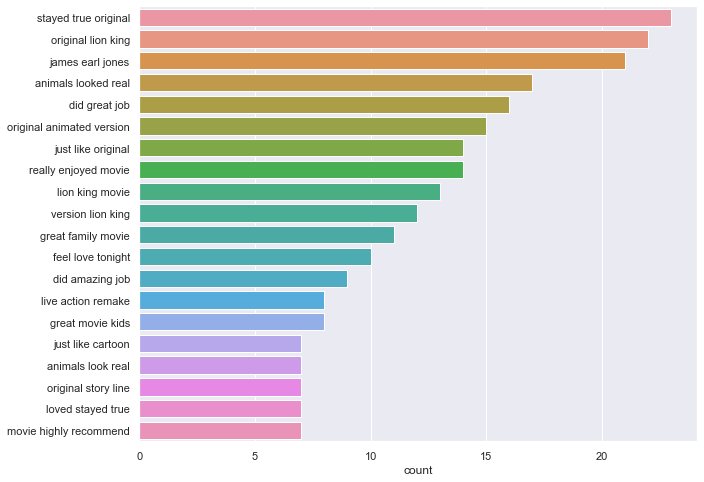

In [35]:
positive_review = train_data[train_data['sensitivity'] == 0]['review']
trigram_df = get_top_n_gram(positive_review, 3, 20)
get_ngram_graph(trigram_df)

# The plot shows the movie is equally good compared it with the original animated movie
# James Earl Jones voice for one character in the move is much appreciated
# CGI is good (animals looked real)
# Family audience likes it
# "Feel love tonight" song by Beyonce is liked by more people

### Trigram plot of negative reviews

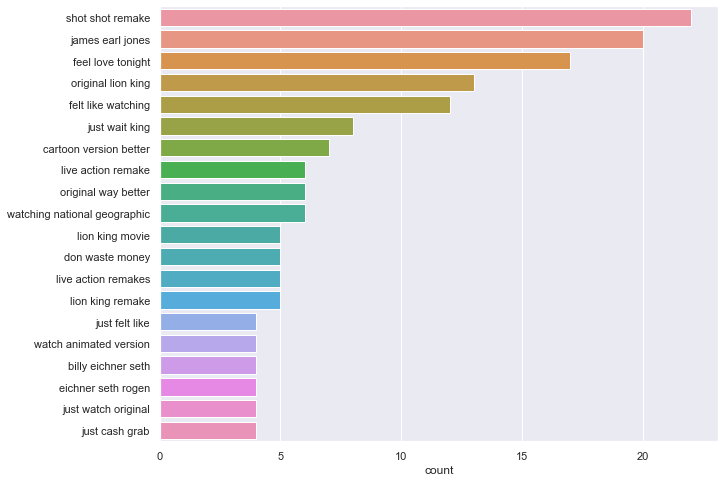

In [36]:
negative_review = train_data[train_data['sensitivity'] == 1]['review']
trigram_df = get_top_n_gram(negative_review, 3, 20)
get_ngram_graph(trigram_df)

# The plot shows the negative reviews are because of no new elements. Shot for shot its remake. Few did not like it
# James earl jones is much talked in negative reviews. When checked the actual reviews, found that 
# the users felt james is the only positive in the movie though they did not like the rest
# Few users said watching the animation version was better
# With the best CGI they felt like watching a national geograpic, as they are not emotinally connected
# billy eichner and seth rogen voices are let down
# Many did not like "Feel love tonight" song by beyonce as well

### Trigram plot of negative reviews by Verified users

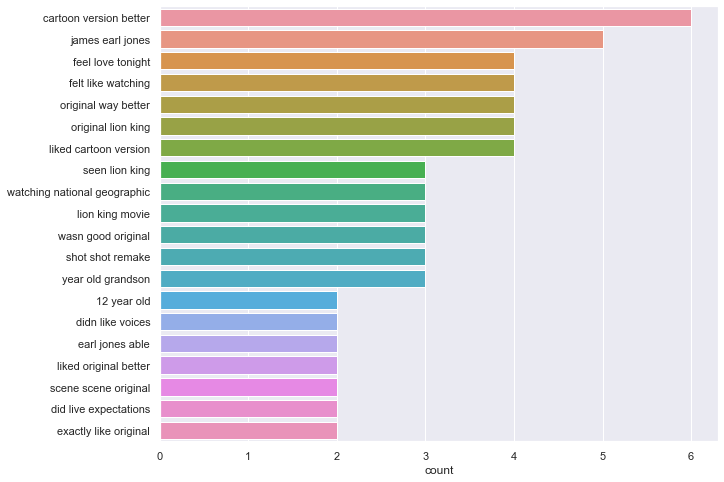

In [37]:
verified_negative_review = train_data[(train_data['sensitivity'] == 1) & (train_data['isVerified'] == True)]['review']
trigram_df = get_top_n_gram(verified_negative_review, 3, 20)
get_ngram_graph(trigram_df)

# Plotted this graph to compare negative reviews of verified users with unverified users, to check if the latter was genuine

### Trigram plot of negative reviews by unverified users

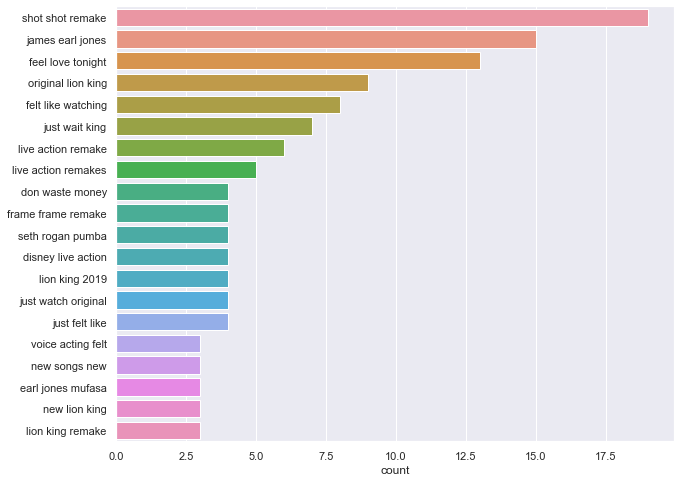

In [56]:
not_verified_negative_review = train_data[(train_data['sensitivity'] == 1) & (train_data['isVerified'] == False)]['review']
trigram_df = get_top_n_gram(not_verified_negative_review, 3, 20)
get_ngram_graph(trigram_df)

# By comparing it with verified users we can say that the negative reviews of unverified users are mostly genuine

#### Lemmatizing train and test data

In [13]:
train_data = train_data[['review','sensitivity']]

In [14]:
train_data.head()

,review,sensitivity
0,"Unlike some other Disney remakes, this one is ...",1
1,Loved the movie!! The music was and is great!!...,0
2,It was a well made movie. I,0
3,They took all of the puns out!! They took the ...,1
4,Loved it! I am a huge fan of the original so I...,0


In [15]:
def process_text(reviews):
    tokenizer = regextoken('\w+')
    reg_tokens = tokenizer.tokenize(reviews)
    tokens = []
    token_lamt=[]
    tokens = [word.lower() for word in reg_tokens if word.lower() not in stopwords.words('english')]
    lmtzr = WordNetLemmatizer()
    token_lamt = [lmtzr.lemmatize(word) for word in tokens]
    lemt_review = ' '.join(word for word in token_lamt)
    return lemt_review

In [16]:
lemmatized_review = []
for review in train_data['review']:
    lemmatized_review.append(process_text(review))

In [17]:
len(lemmatized_review)

3000

In [18]:
train_data['lemmatized_review'] = lemmatized_review

In [19]:
train_data.head()

,review,sensitivity,lemmatized_review
0,"Unlike some other Disney remakes, this one is ...",1,unlike disney remake one pretty much exact ori...
1,Loved the movie!! The music was and is great!!...,0,loved movie music great liked live action
2,It was a well made movie. I,0,well made movie
3,They took all of the puns out!! They took the ...,1,took pun took funny light hearted joke destroy...
4,Loved it! I am a huge fan of the original so I...,0,loved huge fan original missed one liner used ...


In [180]:
del train_data['review']

In [181]:
train_data.head()

,sensitivity,lemmatized_review
0,1,unlike disney remake one pretty much exact ori...
1,0,loved movie music great liked live action
2,0,well made movie
3,1,took pun took funny light hearted joke destroy...
4,0,loved huge fan original missed one liner used ...


In [182]:
train_data.dtypes

sensitivity          category
lemmatized_review      object
dtype: object

In [34]:
test_data = pd.read_csv("C:\\Users\\MANOJ\\Desktop\\Insofe\\PHD\\code\\test.csv", sep=',', header=0, na_values='unknown')

In [35]:
test_data.head(2)

,ReviewID,review
0,92876,Was good. Nothing like the original but I beli...
1,92877,I absolutely loved it! A wonderful rendition o...


In [36]:
del test_data['ReviewID']

In [271]:
lemmatized_test_review = []
for review in test_data['review']:
    lemmatized_test_review.append(process_text(review))

In [272]:
test_data['lemmatized_review'] = lemmatized_test_review

In [273]:
del test_data['review']

In [40]:
test_data.head(2)

,lemmatized_review
0,good nothing like original believe point
1,absolutely loved wonderful rendition original ...


#### Train validation split

In [183]:
X = train_data.lemmatized_review
y = train_data.sensitivity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 1234)

In [184]:
X_train.shape

(1800,)

In [185]:
X_test.shape

(1200,)

## Model Building

In [187]:
# This function calculates confusion matrix, f1 score and accuracy from the predicted data
def calculate_outcome(y_test, y_pred):
    print('Accuracy: %s' % accuracy_score(y_test, y_pred))
    confusion_matrix_test = confusion_matrix(y_test, y_pred)
    Precision_Test = (confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1]))
    Recall_Test = (confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1]))
    print('Precision: ',Precision_Test)
    print('Recall: ',Recall_Test)
    f1_score = (2 * Precision_Test * Recall_Test) / (Precision_Test + Recall_Test)
    print("F1 Score: ",f1_score)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    average_precision = average_precision_score(y_test, y_pred)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Binary-class Precision-Recall curve')

# The function accepts any model as its parameter and fits train and validation data in it and predicts the results 
def fit_model(model):
    nb = Pipeline([('vect', TfidfVectorizer()),
                   ('clf', model),
                  ])
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    test_pred = nb.predict(test_data['lemmatized_review'])
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    calculate_outcome(y_test, y_pred)
    return test_pred

### Naive Bayes classifier

Confusion matrix:
[[866   5]
 [287  42]]
Accuracy: 0.7566666666666667
Precision:  0.8936170212765957
Recall:  0.1276595744680851
F1 Score:  0.22340425531914893
Average precision-recall score: 0.35


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

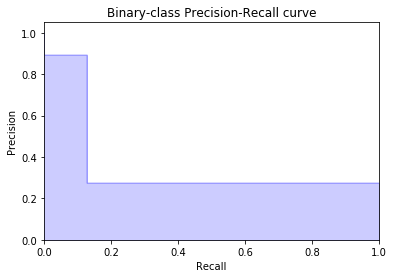

In [188]:
fit_model(MultinomialNB())

### Logistic Regression

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion matrix:
[[737 134]
 [129 200]]
Accuracy: 0.7808333333333334
Precision:  0.5988023952095808
Recall:  0.60790273556231
F1 Score:  0.6033182503770739
Average precision-recall score: 0.47


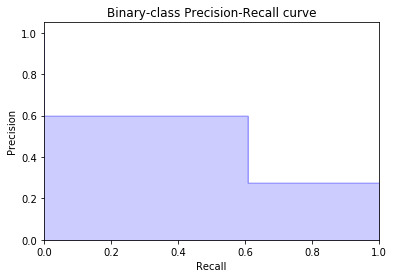

In [41]:
fit_model(LogisticRegression(n_jobs=1, C=1e5))

Confusion matrix:
[[829  42]
 [185 144]]
Accuracy: 0.8108333333333333
Precision:  0.7741935483870968
Recall:  0.4376899696048632
F1 Score:  0.5592233009708737
Average precision-recall score: 0.49


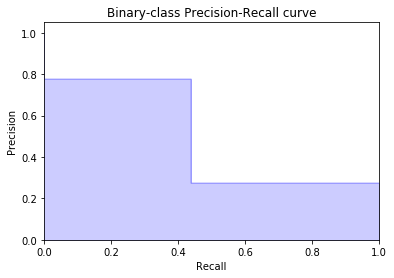

In [42]:
fit_model(LogisticRegression())

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaco

Confusion matrix:
[[777  94]
 [133 196]]
Accuracy: 0.8108333333333333
Precision:  0.6758620689655173
Recall:  0.5957446808510638
F1 Score:  0.6332794830371566
Average precision-recall score: 0.51


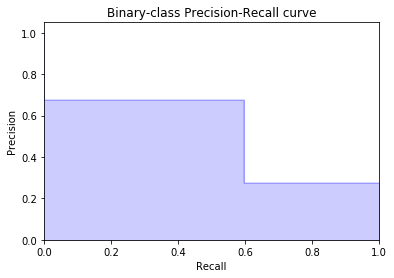

In [43]:
fit_model(LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial'))

### Linear Support Vector Machine

Confusion matrix:
[[820  51]
 [167 162]]
Accuracy: 0.8183333333333334
Precision:  0.7605633802816901
Recall:  0.49240121580547114
F1 Score:  0.5977859778597785
Average precision-recall score: 0.51


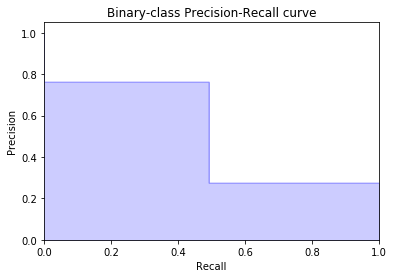

In [46]:
fit_model(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))

Confusion matrix:
[[777  94]
 [130 199]]
Accuracy: 0.8133333333333334
Precision:  0.6791808873720137
Recall:  0.6048632218844985
F1 Score:  0.639871382636656
Average precision-recall score: 0.52


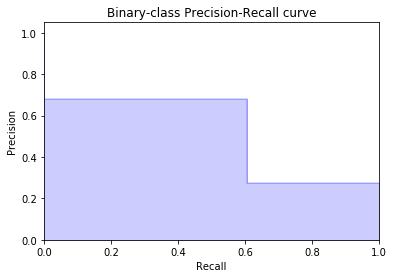

In [62]:
test_pred = fit_model(SGDClassifier(penalty='l2'))

In [487]:
pd.DataFrame(test_pred).to_csv("test_result_sgd.csv")

Confusion matrix:
[[777  94]
 [133 196]]
Accuracy: 0.8108333333333333
Precision:  0.6758620689655173
Recall:  0.5957446808510638
F1 Score:  0.6332794830371566
Average precision-recall score: 0.51


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

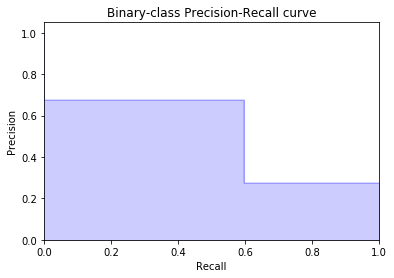

In [64]:
fit_model(SGDClassifier())

### Random Forest

Confusion matrix:
[[839  32]
 [208 121]]
Accuracy: 0.8
Precision:  0.7908496732026143
Recall:  0.3677811550151976
F1 Score:  0.5020746887966805
Average precision-recall score: 0.46


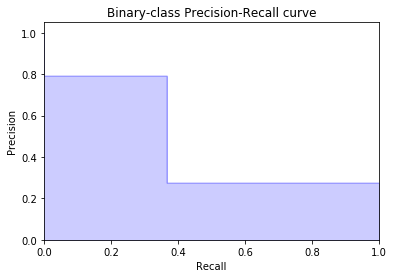

In [408]:
fit_model(RandomForestClassifier(n_estimators=500, max_depth=100, random_state=0))

### KNN

Confusion matrix:
[[835  36]
 [233  96]]
Accuracy: 0.7758333333333334
Precision:  0.7272727272727273
Recall:  0.2917933130699088
F1 Score:  0.41648590021691967
Average precision-recall score: 0.41


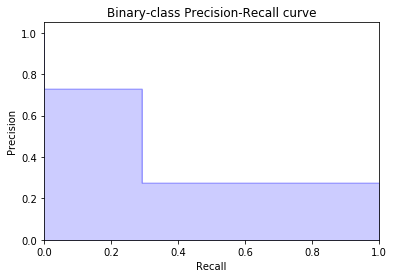

In [410]:
fit_model(KNeighborsClassifier())

### Bagging

Confusion matrix:
[[871   0]
 [326   3]]
Accuracy: 0.7283333333333334
Precision:  1.0
Recall:  0.00911854103343465
F1 Score:  0.018072289156626505
Average precision-recall score: 0.28


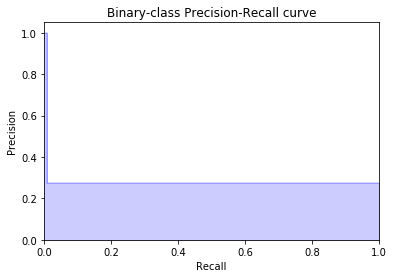

In [411]:
fit_model(BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5))

### AdaBoost

Confusion matrix:
[[780  91]
 [154 175]]
Accuracy: 0.7958333333333333
Precision:  0.6578947368421053
Recall:  0.5319148936170213
F1 Score:  0.5882352941176471
Average precision-recall score: 0.48


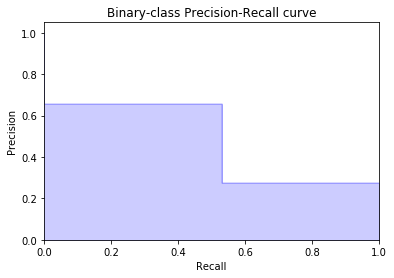

In [412]:
fit_model(AdaBoostClassifier(n_estimators=100))

### Gradient Boosting

Confusion matrix:
[[838  33]
 [204 125]]
Accuracy: 0.8025
Precision:  0.7911392405063291
Recall:  0.3799392097264438
F1 Score:  0.5133470225872689
Average precision-recall score: 0.47


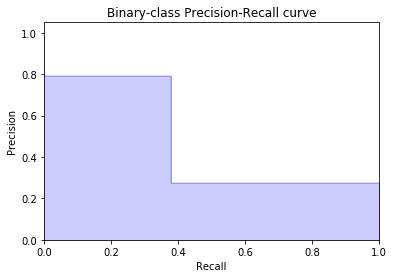

In [413]:
fit_model(GradientBoostingClassifier())

### Grid Search

In [298]:
clf_gbm = Pipeline(steps=[('GBM', GradientBoostingClassifier())])

gbm_param_grid = {'GBM__max_depth': [16], 'GBM__subsample': [0.4, 0.6], 'GBM__max_features':[0.2], 
              'GBM__n_estimators': [20]}

gbm_grid = GridSearchCV(clf_gbm, param_grid=gbm_param_grid, cv=3, verbose=3)

gbm_grid.fit(X_train_vec,y_train_vec)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.4 
[CV]  GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.4, score=0.780, total=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.4 
[CV]  GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.4, score=0.758, total=   1.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.4 
[CV]  GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.4, score=0.802, total=   1.8s
[CV] GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.6 
[CV]  GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.6, score=0.788, total=   2.6s
[CV] GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.6 
[CV]  GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.6, score=0.755, total=   2.5s
[CV] GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.6 
[CV]  GBM__max_depth=16, GBM__max_features=0.2, GBM__n_estimators=20, GBM__subsample=0.6, score=0.800, total=   2.4s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('GBM',
                                        GradientBoostingClassifier(criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min_samp

In [299]:
test_pred = gbm_grid.predict(X_test_vec)

print(confusion_matrix(y_true=y_test_vec, y_pred = test_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test_vec, y_pred =  test_pred)


Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Train Accuracy: ",Accuracy_test)

[[824  47]
 [198 131]]
Test Precision:  0.7359550561797753
Test Recall:  0.3981762917933131
Train Accuracy:  0.7958333333333333


#### Vectorize the lemmatized review and then split the vector to train and validation

In [261]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_review'])
vectorized_train_data = pd.DataFrame(tfidf.toarray(), columns= tfidf_vectorizer.get_feature_names())
vectorized_train_data['sensitivity'] = train_data.sensitivity

In [35]:
X_vec = vectorized_train_data.iloc[:,:-1]
y_vec = vectorized_train_data.sensitivity
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X_vec, y_vec, test_size=0.4, random_state = 1234)

In [36]:
X_train_vec.shape

(1800, 4269)

In [37]:
X_test_vec.shape

(1200, 4269)

In [186]:
tfidf_test = tfidf_vectorizer.transform(test_data['lemmatized_review'])
vectorized_test_data = pd.DataFrame(tfidf_test.toarray(), columns= tfidf_vectorizer.get_feature_names())

#### Apply Smote on the vector and then do Grid Search

In [307]:
smote = SMOTE(random_state=0)


os_data_X,os_data_y=smote.fit_sample(X_train_vec,y_train_vec)

os_data_X = pd.DataFrame(data=os_data_X)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

In [315]:
clf_gbm = Pipeline(steps=[('GBM', GradientBoostingClassifier())])

gbm_param_grid = {'GBM__max_depth': [100], 'GBM__subsample': [0.4, 0.6], 'GBM__max_features':[0.4, 0.6], 
              'GBM__n_estimators': [500]}

gbm_grid = GridSearchCV(clf_gbm, param_grid=gbm_param_grid, cv=3, verbose=3)

gbm_grid.fit(os_data_X,os_data_y)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.4 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.4, score=0.779, total= 2.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV] GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.4 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.4, score=0.875, total= 4.0min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.9min remaining:    0.0s


[CV] GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.4 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.4, score=0.886, total= 3.9min
[CV] GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.6 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.6, score=0.785, total= 2.6min
[CV] GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.6 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.6, score=0.889, total= 3.9min
[CV] GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.6 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.4, GBM__n_estimators=500, GBM__subsample=0.6, score=0.895, total= 7.0min
[CV] GBM__max_depth=100, GBM__max_features=0.6, GBM__n_estimators=500, GBM__subsample=0.4 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.6, GBM__n_estimators=500, GBM__subsample=0.4, score=0.792, total= 7.8min
[CV] GBM__max_depth=100, GBM__max_features=0.6, GBM__n_estimators=500, GBM__subsample=0.4 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.6, GBM__n_estimators=500, GBM__subsample=0.4, score=0.883, total=10.4min
[CV] GBM__max_depth=100, GBM__max_features=0.6, GBM__n_estimators=500, GBM__subsample=0.4 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  GBM__max_depth=100, GBM__max_features=0.6, GBM__n_estimators=500, GBM__subsample=0.4, score=0.888, total=10.9min
[CV] GBM__max_depth=100, GBM__max_features=0.6, GBM__n_estimators=500, GBM__subsample=0.6 


C:\Python\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [ ]:
test_pred = gbm_grid.predict(X_test_vec)

print(confusion_matrix(y_true=y_test_vec, y_pred = test_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test_vec, y_pred =  test_pred)


Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Train Accuracy: ",Accuracy_test)

In [ ]:
f1_score = (2 * Precision_Test * Recall_Test) / (Precision_Test + Recall_Test)
print("F1 Score: ",f1_score)

### Simple Deep Neural Network

In [60]:
def TFIDF(X_train, X_test,MAX_NB_WORDS=75000):
    vectorizer_x = TfidfVectorizer(max_features=MAX_NB_WORDS)
    X_train = vectorizer_x.fit_transform(X_train).toarray()
    X_test = vectorizer_x.transform(X_test).toarray()
    print("tf-idf with",str(np.array(X_train).shape[1]),"features")
    return (X_train,X_test)

In [61]:
def Build_Model_DNN_Text(shape, nClasses, dropout=0.5):
    """
    buildModel_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    nClasses is number of classes
    """
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [64]:
X_train_tfidf,X_test_tfidf = TFIDF(X_train,X_test)
model_DNN = Build_Model_DNN_Text(X_train_tfidf.shape[1], 2)
model_DNN.fit(X_train_tfidf, y_train,
                              validation_data=(X_test_tfidf, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=2)
y_pred = model_DNN.predict(X_test_tfidf)

tf-idf with 3273 features
Train on 1800 samples, validate on 1200 samples
Epoch 1/10
 - 6s - loss: 0.6133 - acc: 0.7217 - val_loss: 0.6195 - val_acc: 0.7258
Epoch 2/10
 - 1s - loss: 0.5377 - acc: 0.7217 - val_loss: 0.4803 - val_acc: 0.7258
Epoch 3/10
 - 1s - loss: 0.3744 - acc: 0.7217 - val_loss: 0.4067 - val_acc: 0.7258
Epoch 4/10
 - 2s - loss: 0.2731 - acc: 0.8772 - val_loss: 0.4215 - val_acc: 0.8117
Epoch 5/10
 - 1s - loss: 0.2277 - acc: 0.9622 - val_loss: 0.6717 - val_acc: 0.8175
Epoch 6/10
 - 1s - loss: 0.1638 - acc: 0.9750 - val_loss: 0.6807 - val_acc: 0.8142
Epoch 7/10
 - 1s - loss: 0.0686 - acc: 0.9817 - val_loss: 1.0084 - val_acc: 0.8167
Epoch 8/10
 - 1s - loss: 0.0531 - acc: 0.9856 - val_loss: 0.9508 - val_acc: 0.8175
Epoch 9/10
 - 1s - loss: 0.0322 - acc: 0.9900 - val_loss: 0.7806 - val_acc: 0.8142
Epoch 10/10
 - 1s - loss: 0.0183 - acc: 0.9956 - val_loss: 0.8918 - val_acc: 0.8033


In [68]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [67]:
y_pred = np.argmax(y_pred, axis=1)

Confusion matrix:
[[871   0]
 [329   0]]
Accuracy: 0.7258333333333333


C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  after removing the cwd from sys.path.


Precision:  nan
Recall:  0.0
F1 Score:  nan
Average precision-recall score: 0.27


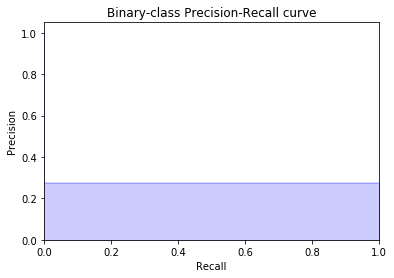

In [70]:
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

## RNN

In [100]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open("C:\\Users\\MANOJ\\Desktop\\Insofe\\PHD\\code\\glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [106]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    gru_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False))
    print(gru_node)
    for i in range(0,hidden_layer):
        model.add(GRU(gru_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
    model.add(GRU(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    print(model.summary())
    return model

In [107]:
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 2)
model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=2)
y_pred = model_RNN.predict_classes(X_test_Glove)

Found 4291 unique tokens.
(3000, 500)
Total 400000 word vectors.
32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 50)           214600    
_________________________________________________________________
gru_9 (GRU)                  (None, 500, 32)           7968      
_________________________________________________________________
dropout_12 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 500, 32)           6240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
gru_11 (GRU)                 (None, 500, 32)           6240      
_________________________________________________________________
dropout_

Confusion matrix:
[[696 175]
 [128 201]]
Accuracy: 0.7475
Precision:  0.5345744680851063
Recall:  0.6109422492401215
F1 Score:  0.5702127659574467
Average precision-recall score: 0.43


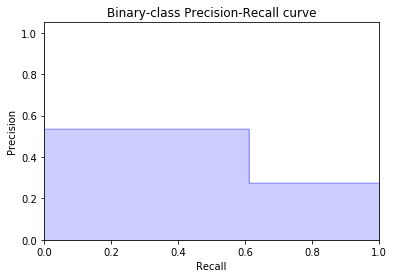

In [108]:
y_pred = model_RNN.predict_classes(X_test_Glove)
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

## CNN

In [49]:
def Build_Model_CNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
        def buildModel_CNN(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
        word_index in word index ,
        embeddings_index is embeddings index, look at data_helper.py
        nClasses is number of classes,
        MAX_SEQUENCE_LENGTH is maximum lenght of text sequences,
        EMBEDDING_DIM is an int value for dimention of word embedding look at data_helper.py
    """
    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))
    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        #l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)
    l_merge = concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(1, activation='sigmoid')(l_dense)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [50]:
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
model_CNN = Build_Model_CNN_Text(word_index,embeddings_index, 2)
model_CNN.summary()
model_CNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=20,
                              batch_size=128,
                              verbose=2)
predicted = model_CNN.predict(X_test_Glove)
y_pred = np.argmax(predicted, axis=1)

Found 4291 unique tokens.
(3000, 500)
Total 400000 word vectors.
Filter   5


TypeError: concatenate() missing 1 required positional argument: 'inputs'

In [ ]:
y_pred = model_RNN.predict_classes(X_test_Glove)
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

## RCNN

In [55]:
def Build_Model_RCNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [58]:
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
model_RCNN = Build_Model_RCNN_Text(word_index,embeddings_index, 2)
model_RCNN.summary()
model_RCNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=2)
predicted = model_RCNN.predict(X_test_Glove)
y_pred = np.argmax(predicted, axis=1)

Found 4291 unique tokens.
(3000, 500)
Total 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 50)           214600    
_________________________________________________________________
dropout_19 (Dropout)         (None, 500, 50)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 499, 256)          25856     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 249, 256)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 248, 256)          131328    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 124, 256)          0         
_________________________________________________________________
conv1d_11 (

Confusion matrix:
[[871   0]
 [329   0]]
Accuracy: 0.7258333333333333


C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  after removing the cwd from sys.path.


Precision:  nan
Recall:  0.0
F1 Score:  nan
Average precision-recall score: 0.27


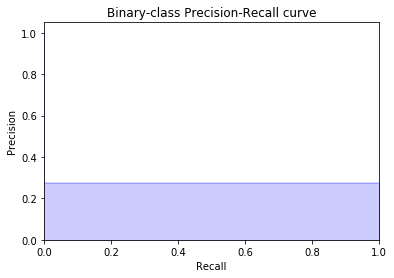

In [59]:
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

## Word2vec from GoogleNews

In [261]:
# This will load 3M word vectors with 300 dimension each from the pretrained module GoogleNews
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [323]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])

In [324]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(train_data, test_size=0.4, random_state = 1234)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['lemmatized_review']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['lemmatized_review']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
W0828 06:09:38.156131  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['ahhhhhhh', 'savenyahhhhhh']
W0828 06:09:38.489972  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['ahhhhhhh', 'savenyahhhhh', 'drebii', 'baraboooooooo']
W0828 06:09:40.073662  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['encanto', 'pumba', 'timón']


In [165]:
X_test_word_average.shape

(1200, 300)

### Logistic Regression

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy 0.8266666666666667
Confusion matrix:
[[807  64]
 [144 185]]
Accuracy: 0.8266666666666667
Precision:  0.7429718875502008
Recall:  0.5623100303951368
F1 Score:  0.6401384083044983
Average precision-recall score: 0.54


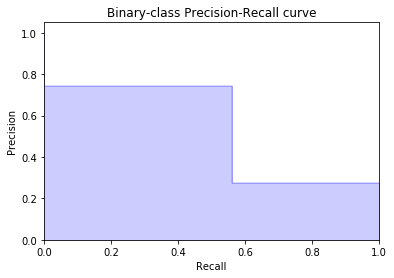

In [167]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train_word_average, train['sensitivity'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.sensitivity))
print('Confusion matrix:')
print(confusion_matrix(test.sensitivity, y_pred))
calculate_outcome(test.sensitivity, y_pred)

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaco

accuracy 0.8183333333333334
Confusion matrix:
[[785  86]
 [132 197]]
Accuracy: 0.8183333333333334
Precision:  0.696113074204947
Recall:  0.5987841945288754
F1 Score:  0.6437908496732025
Average precision-recall score: 0.53


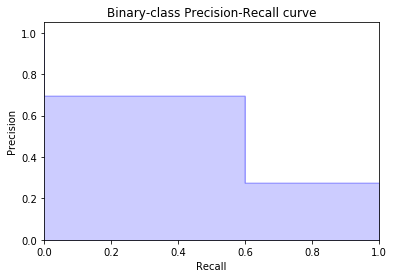

In [160]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
logreg_cv = logreg_cv.fit(X_train_word_average, train['sensitivity'])
y_pred_cv = logreg_cv.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred_cv, test.sensitivity))
print('Confusion matrix:')
print(confusion_matrix(test.sensitivity, y_pred_cv))
calculate_outcome(test.sensitivity, y_pred_cv)

## SVD on TFIDF Vector

In [263]:
U, Sigma, VT = randomized_svd(tfidf, n_components=500)

In [85]:
U

array([[ 2.14464071e-02, -2.50958610e-02, -2.94523526e-03, ...,
        -1.09269037e-02,  4.34737365e-02,  1.70411131e-02],
       [ 3.91712002e-02,  3.38579584e-02,  9.41369666e-03, ...,
        -8.87170996e-03,  5.60916020e-03,  2.58117464e-03],
       [ 2.28880098e-02, -2.15588611e-05,  1.77677495e-02, ...,
         2.76455603e-03,  5.44308470e-03, -2.73584086e-03],
       ...,
       [ 1.09086860e-02, -4.82823888e-03,  8.62891509e-04, ...,
         2.90364876e-02, -1.85880029e-02, -2.46436349e-02],
       [ 1.12051775e-02, -3.06259485e-03,  4.24454577e-03, ...,
        -3.05640121e-03,  4.10358490e-03, -1.50207242e-02],
       [ 1.85068169e-02, -3.60242680e-03,  8.55269094e-03, ...,
        -8.13149535e-03,  7.37460361e-03, -3.39894171e-03]])

In [264]:
X_train_noisefree = np.dot(U,np.diag(Sigma))
X_train_noisefree = np.dot(X_train_noisefree, VT)

In [92]:
train_data_svd = pd.DataFrame(X_train_noisefree)
train_data_svd['sensitivity'] = train_data.sensitivity

In [87]:
train_data_svd = pd.DataFrame(U)
train_data_svd['sensitivity'] = train_data.sensitivity

In [93]:
train_data_svd.head()

,0,1,2,3,4,5,6,7,8,9,...,4260,4261,4262,4263,4264,4265,4266,4267,4268,sensitivity
0,0.001479,0.002107,-0.000288,0.009265,-0.003338,0.000543,0.002709,-0.002859,0.002122,-0.001389,...,0.004908,-0.001374,-0.000112,0.000616,0.016386,-0.000430,0.002062,-0.000300,-0.000960,1
1,-0.000223,-0.000306,-0.000167,0.001991,0.003295,-0.001289,-0.001412,-0.000318,-0.000472,-0.000446,...,-0.001651,-0.000291,-0.000559,-0.000377,0.002482,-0.000314,-0.000415,-0.001041,-0.001913,0
2,-0.000096,0.002377,-0.000663,-0.002319,0.001577,-0.000230,-0.000066,0.010988,0.000781,-0.000217,...,-0.002345,0.000979,0.002319,-0.001531,-0.000205,-0.000372,-0.000298,0.003077,0.000674,0
3,0.002274,-0.002463,-0.004012,0.001477,0.001174,0.000559,-0.004369,-0.013480,-0.000843,0.002954,...,-0.005303,0.002207,-0.001512,-0.003197,-0.000581,-0.001890,0.002950,-0.000594,0.001533,1
4,-0.000886,-0.002266,-0.000755,-0.002790,-0.000402,-0.000785,-0.006966,0.002332,0.000530,0.000123,...,-0.013777,0.002903,-0.000257,0.001212,-0.009694,-0.000958,0.001505,-0.005462,-0.005525,0


In [94]:
X_svd = train_data_svd.iloc[:,:-1]
y_svd = train_data_svd.sensitivity
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y_svd, test_size=0.4, random_state = 1234)

### SVC

accuracy 0.8091666666666667
Confusion matrix:
[[763 108]
 [121 208]]
Accuracy: 0.8091666666666667
Precision:  0.6582278481012658
Recall:  0.6322188449848024
F1 Score:  0.6449612403100774
Average precision-recall score: 0.52


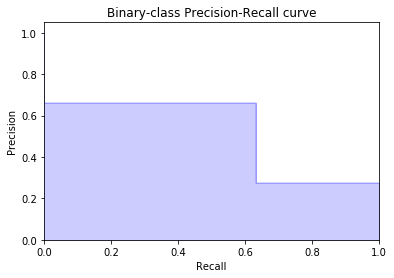

In [107]:
sgd = SGDClassifier()
sgd = sgd.fit(X_train_svd, y_train_svd)
y_pred_sgd = sgd.predict(X_test_svd)
print('accuracy %s' % accuracy_score(y_pred_sgd, y_test_svd))
print('Confusion matrix:')
print(confusion_matrix(y_test_svd, y_pred_sgd))
calculate_outcome(y_test_svd, y_pred_sgd)

In [279]:
U_test, Sigma_test, VT_test = randomized_svd(tfidf_test, n_components=500)
test_noisefree = np.dot(U_test,np.diag(Sigma_test))
test_noisefree = np.dot(test_noisefree, VT_test)
test_data_svd = pd.DataFrame(test_noisefree)

In [123]:
y_pred_sgd_svd = sgd.predict(test_data_svd)

In [125]:
pd.DataFrame(y_pred_sgd_svd).to_csv("test_result_sgd_svd.csv")

### SVC on SVD vector after applying Smote

In [126]:
smote = SMOTE(random_state=0)


X_smote,y_smote=smote.fit_sample(X_train_svd,y_train_svd)

X_train_smote = pd.DataFrame(data=X_smote)
y_train_smote= pd.DataFrame(data=y_smote,columns=['sensitivity'])

C:\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy 0.8091666666666667
Confusion matrix:
[[717 154]
 [ 83 246]]
Accuracy: 0.8025
Precision:  0.615
Recall:  0.7477203647416414
F1 Score:  0.6748971193415638
Average precision-recall score: 0.53


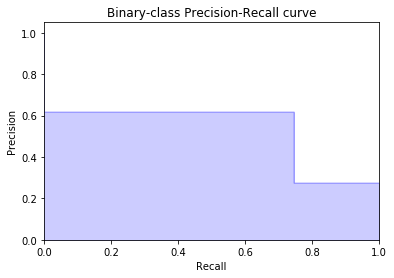

In [133]:
sgd_smote = SGDClassifier()
sgd_smote = sgd_smote.fit(X_train_smote, y_train_smote)
y_pred_sgd_smote = sgd_smote.predict(X_test_svd)
print('accuracy %s' % accuracy_score(y_pred_sgd, y_test_svd))
print('Confusion matrix:')
print(confusion_matrix(y_test_svd, y_pred_sgd_smote))
calculate_outcome(y_test_svd, y_pred_sgd_smote)

In [134]:
y_pred_sgd_svd_smote = sgd_smote.predict(test_data_svd)
pd.DataFrame(y_pred_sgd_svd_smote).to_csv("test_result_sgd_svd_smote.csv")

### Logistic Regression on SVD vector after applying Smote

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy 0.8091666666666667
Confusion matrix:
[[710 161]
 [ 67 262]]
Accuracy: 0.81
Precision:  0.6193853427895981
Recall:  0.7963525835866262
F1 Score:  0.696808510638298
Average precision-recall score: 0.55


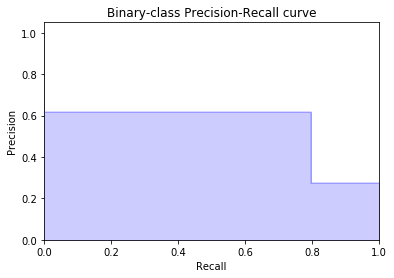

In [139]:
sgd_smote = LogisticRegression()
sgd_smote = sgd_smote.fit(X_train_smote, y_train_smote)
y_pred_sgd_smote = sgd_smote.predict(X_test_svd)
print('accuracy %s' % accuracy_score(y_pred_sgd, y_test_svd))
print('Confusion matrix:')
print(confusion_matrix(y_test_svd, y_pred_sgd_smote))
calculate_outcome(y_test_svd, y_pred_sgd_smote)

In [140]:
y_pred_logreg_svd_smote = sgd_smote.predict(test_data_svd)
pd.DataFrame(y_pred_logreg_svd_smote).to_csv("test_result_logreg_svd_smote.csv")

In [141]:
y_pred_logreg_svd_smote

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

### Logistic Regression CV on SVD vector after applying Smote

C:\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iter

accuracy 0.8091666666666667
Confusion matrix:
[[735 136]
 [ 82 247]]
Accuracy: 0.8183333333333334
Precision:  0.6449086161879896
Recall:  0.7507598784194529
F1 Score:  0.6938202247191012
Average precision-recall score: 0.55


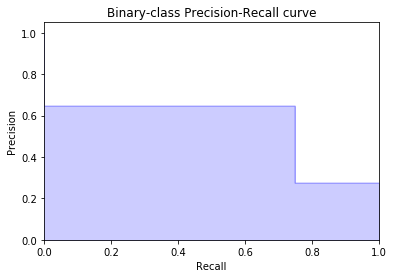

In [147]:
sgd_smote = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
sgd_smote = sgd_smote.fit(X_train_smote, y_train_smote)
y_pred_sgd_smote = sgd_smote.predict(X_test_svd)
print('accuracy %s' % accuracy_score(y_pred_sgd, y_test_svd))
print('Confusion matrix:')
print(confusion_matrix(y_test_svd, y_pred_sgd_smote))
calculate_outcome(y_test_svd, y_pred_sgd_smote)

In [148]:
y_pred_logregcv_svd_smote = sgd_smote.predict(test_data_svd)
pd.DataFrame(y_pred_logregcv_svd_smote).to_csv("test_result_logregcv_svd_smote.csv")

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy 0.8091666666666667
Confusion matrix:
[[710 161]
 [ 67 262]]
Accuracy: 0.81
Precision:  0.6193853427895981
Recall:  0.7963525835866262
F1 Score:  0.696808510638298
Average precision-recall score: 0.55


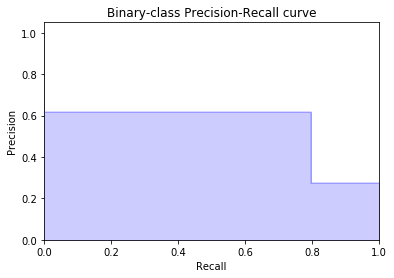

In [154]:
sgd_smote = LogisticRegression()
sgd_smote = sgd_smote.fit(X_train_smote, y_train_smote)
y_pred_sgd_smote = sgd_smote.predict(X_test_svd)
print('accuracy %s' % accuracy_score(y_pred_sgd, y_test_svd))
print('Confusion matrix:')
print(confusion_matrix(y_test_svd, y_pred_sgd_smote))
calculate_outcome(y_test_svd, y_pred_sgd_smote)

## Find Review Polarity


#### Polarity on raw review text

In [162]:
sid = SentimentIntensityAnalyzer()
train_data_polar=pd.DataFrame()
for word in train_data['review']:
    ss = sid.polarity_scores(word)
    temp_df=pd.DataFrame(ss, index=range(1))
    train_data_polar=train_data_polar.append(temp_df,ignore_index=True)

In [238]:
train_data_polar.head()

,neg,neu,pos,compound
0,0.000,0.758,0.242,0.9270
1,0.000,0.455,0.545,0.9180
2,0.000,0.656,0.344,0.2732
3,0.073,0.733,0.194,0.6467
4,0.084,0.589,0.327,0.8034


#### Polarity on lemmatized review text

In [372]:
sid = SentimentIntensityAnalyzer()
train_data_polar_2=pd.DataFrame()
for word in train_data['lemmatized_review']:
    ss = sid.polarity_scores(word)
    temp_df=pd.DataFrame(ss, index=range(1))
    train_data_polar_2=train_data_polar_2.append(temp_df,ignore_index=True)

In [373]:
train_data_polar_2.head()

,neg,neu,pos,compound
0,0.000,0.570,0.430,0.9270
1,0.000,0.270,0.730,0.8957
2,0.000,0.488,0.512,0.2732
3,0.117,0.586,0.297,0.5994
4,0.116,0.316,0.568,0.8225


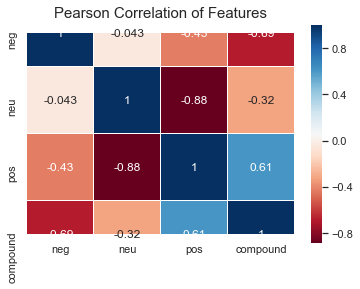

In [239]:
colormap = plt.cm.RdBu
plt.figure(figsize=(6,4))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data_polar.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [240]:
train_data_polar['sensitivity']=train_data.sensitivity

In [241]:
X_polar = train_data_polar.iloc[:,:-1]
y_polar = train_data_polar.sensitivity
X_polar_train, X_polar_test, y_polar_train, y_polar_test = train_test_split(X_polar, y_polar, test_size=0.4, random_state = 1234)

#### Logistic Regression on Polarized data

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy 0.7575
Confusion matrix:
[[787  84]
 [207 122]]
Accuracy: 0.7575
Precision:  0.5922330097087378
Recall:  0.3708206686930091
F1 Score:  0.45607476635514016
Average precision-recall score: 0.39


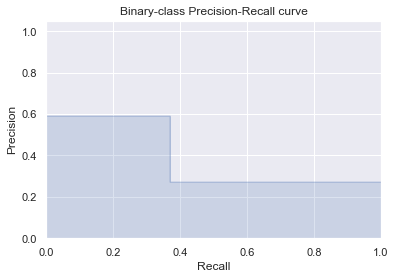

In [242]:
logreg = LogisticRegression()
logreg = logreg.fit(X_polar_train, y_polar_train)
y_pred = logreg.predict(X_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_polar_test, y_pred))
calculate_outcome(y_polar_test, y_pred)

In [227]:
del train_data_polar['pos']

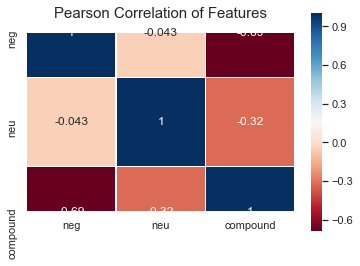

In [229]:
colormap = plt.cm.RdBu
plt.figure(figsize=(6,4))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data_polar.iloc[:,:-1].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [230]:
X_polar = train_data_polar.iloc[:,:-1]
y_polar = train_data_polar.sensitivity
X_polar_train, X_polar_test, y_polar_train, y_polar_test = train_test_split(X_polar, y_polar, test_size=0.4, random_state = 1234)

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy 0.755
Confusion matrix:
[[788  83]
 [211 118]]
Accuracy: 0.755
Precision:  0.5870646766169154
Recall:  0.3586626139817629
F1 Score:  0.4452830188679245
Average precision-recall score: 0.39


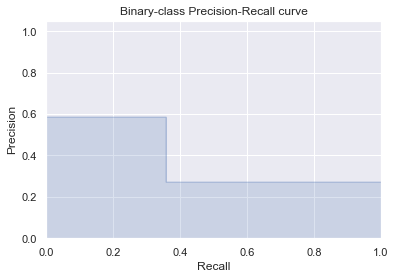

In [232]:
logreg = LogisticRegression()
logreg = logreg.fit(X_polar_train, y_polar_train)
y_pred = logreg.predict(X_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_polar_test, y_pred))
calculate_outcome(y_polar_test, y_pred)

In [233]:
del train_data_polar['compound']

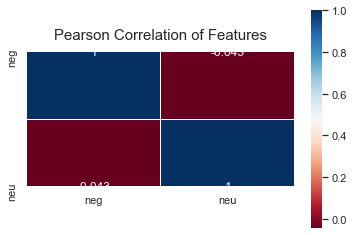

In [234]:
colormap = plt.cm.RdBu
plt.figure(figsize=(6,4))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data_polar.iloc[:,:-1].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [235]:
X_polar = train_data_polar.iloc[:,:-1]
y_polar = train_data_polar.sensitivity
X_polar_train, X_polar_test, y_polar_train, y_polar_test = train_test_split(X_polar, y_polar, test_size=0.4, random_state = 1234)

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy 0.7608333333333334
Confusion matrix:
[[839  32]
 [255  74]]
Accuracy: 0.7608333333333334
Precision:  0.6981132075471698
Recall:  0.22492401215805471
F1 Score:  0.34022988505747126
Average precision-recall score: 0.37


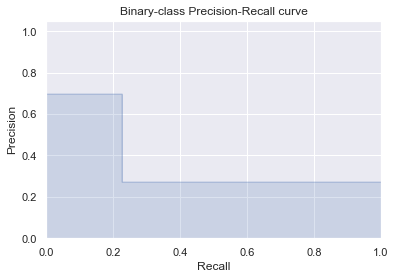

In [236]:
logreg = LogisticRegression()
logreg = logreg.fit(X_polar_train, y_polar_train)
y_pred = logreg.predict(X_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_polar_test, y_pred))
calculate_outcome(y_polar_test, y_pred)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1, score=0.772, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1, score=0.790, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1, score=0.768, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2, score=0.782, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2, score=0.787, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2, score=0.765, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=1, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4, score=0.785, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4, score=0.790, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4, score=0.772, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.5, score=0.785, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=1, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6, score=0.785, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6, score=0.778, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.7, score=0.785, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.7, score=0.788, total=   0.1s
[CV] GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=1, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=2, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=2, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.8, score=0.772, total=   0.1s
[CV] GBM__max_depth=2, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=2, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1, score=0.770, total=   0.1s
[CV] GBM__max_depth=2, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=2, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1, score=0.768, total=   0.1s
[CV] GBM__max_depth=2, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=2, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1, score=0.757, total=   0.1s
[CV] GBM__max_depth=2, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=2, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3, score=0.778, total=   0.1s
[CV] GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3, score=0.780, total=   0.1s
[CV] GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3, score=0.773, total=   0.1s
[CV] GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.4, score=0.768, total=   0.1s
[CV] GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=2, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5, score=0.772, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5, score=0.733, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.6, score=0.780, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.6, score=0.783, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=3, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=3, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=3, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.7, score=0.743, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=3, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8, score=0.770, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=3, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8, score=0.780, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=3, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8, score=0.748, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=3, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2, score=0.763, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2, score=0.773, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2, score=0.748, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.3, score=0.782, total=   0.1s
[CV] GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=3, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.4, score=0.767, total=   0.1s
[CV] GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.4, score=0.740, total=   0.1s
[CV] GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.5, score=0.783, total=   0.1s
[CV] GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.5, score=0.777, total=   0.1s
[CV] GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=4, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.6, score=0.742, total=   0.2s
[CV] GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.7, score=0.768, total=   0.2s
[CV] GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.7, score=0.760, total=   0.2s
[CV] GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.7, score=0.725, total=   0.2s
[CV] GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=4, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.1, score=0.753, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.1, score=0.747, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.1, score=0.717, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.2, score=0.770, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=5, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.3, score=0.760, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.3, score=0.730, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.4, score=0.775, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.4, score=0.757, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=5, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.5, score=0.725, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.6, score=0.770, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.6, score=0.757, total=   0.2s
[CV] GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.6, score=0.735, total=   0.1s
[CV] GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=5, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=6, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=6, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.8, score=0.772, total=   0.2s
[CV] GBM__max_depth=6, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=6, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.8, score=0.758, total=   0.2s
[CV] GBM__max_depth=6, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=6, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.8, score=0.732, total=   0.2s
[CV] GBM__max_depth=6, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=6, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.1, score=0.742, total=   0.1s
[CV] GBM__max_depth=6, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=6, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.2, score=0.758, total=   0.2s
[CV] GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.2, score=0.723, total=   0.2s
[CV] GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.3, score=0.755, total=   0.2s
[CV] GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.3, score=0.748, total=   0.2s
[CV] GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=6, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.4, score=0.723, total=   0.2s
[CV] GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.5, score=0.768, total=   0.2s
[CV] GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.5, score=0.762, total=   0.2s
[CV] GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.5, score=0.727, total=   0.2s
[CV] GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=7, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.7, score=0.763, total=   0.4s
[CV] GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.7, score=0.753, total=   0.3s
[CV] GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.7, score=0.740, total=   0.3s
[CV] GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.8, score=0.758, total=   0.2s
[CV] GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=7, GBM__max_features=0.5, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1, score=0.697, total=   0.2s
[CV] GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.1, score=0.720, total=   0.2s
[CV] GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2, score=0.765, total=   0.2s
[CV] GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2, score=0.753, total=   0.2s
[CV] GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=8, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.3, score=0.735, total=   0.4s
[CV] GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4, score=0.768, total=   0.4s
[CV] GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4, score=0.760, total=   0.4s
[CV] GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.4, score=0.737, total=   0.3s
[CV] GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=8, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6, score=0.758, total=   0.3s
[CV] GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6, score=0.758, total=   0.3s
[CV] GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.6, score=0.717, total=   0.3s
[CV] GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.7, score=0.765, total=   0.3s
[CV] GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=8, GBM__max_features=0.7, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=9, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=9, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.8, score=0.750, total=   0.4s
[CV] GBM__max_depth=9, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=9, GBM__max_features=0.2, GBM__n_estimators=100, GBM__subsample=0.8, score=0.717, total=   0.4s
[CV] GBM__max_depth=9, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=9, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1, score=0.753, total=   0.2s
[CV] GBM__max_depth=9, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=9, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1, score=0.718, total=   0.2s
[CV] GBM__max_depth=9, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=9, GBM__max_features=0.3, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.2, score=0.758, total=   0.3s
[CV] GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3, score=0.753, total=   0.3s
[CV] GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3, score=0.763, total=   0.3s
[CV] GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3 
[CV]  GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.3, score=0.742, total=   0.3s
[CV] GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.4 
[CV]  GBM__max_depth=9, GBM__max_features=0.6, GBM__n_estimators=100, GBM__subsample=0.

[CV] GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5, score=0.763, total=   0.4s
[CV] GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5, score=0.758, total=   0.4s
[CV] GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5 
[CV]  GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.5, score=0.733, total=   0.4s
[CV] GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.6, score=0.750, total=   0.5s
[CV] GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__subsample=0.6 
[CV]  GBM__max_depth=10, GBM__max_features=0.1, GBM__n_estimators=100, GBM__su

[CV] GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.7, score=0.763, total=   0.5s
[CV] GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.7, score=0.750, total=   0.5s
[CV] GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.7 
[CV]  GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.7, score=0.738, total=   0.5s
[CV] GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8, score=0.757, total=   0.5s
[CV] GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__subsample=0.8 
[CV]  GBM__max_depth=10, GBM__max_features=0.4, GBM__n_estimators=100, GBM__su

[CV] GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.1, score=0.752, total=   0.2s
[CV] GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.1, score=0.715, total=   0.2s
[CV] GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.1 
[CV]  GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.1, score=0.720, total=   0.2s
[CV] GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2, score=0.752, total=   0.3s
[CV] GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__subsample=0.2 
[CV]  GBM__max_depth=10, GBM__max_features=0.8, GBM__n_estimators=100, GBM__su

[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed:  6.1min finished


accuracy 0.7833333333333333
Confusion matrix:
[[783  88]
 [172 157]]
Accuracy: 0.7833333333333333
Precision:  0.6408163265306123
Recall:  0.47720364741641336
F1 Score:  0.5470383275261325
Average precision-recall score: 0.45


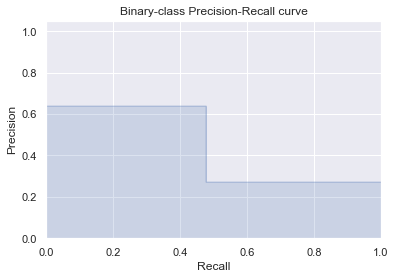

In [260]:
clf_gbm = Pipeline(steps=[('GBM', GradientBoostingClassifier())])

gbm_param_grid = {'GBM__max_depth': [1,2,3,4,5,6,7,8,9,10], 'GBM__subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], 'GBM__max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], 
              'GBM__n_estimators': [100]}

gbm_grid = GridSearchCV(clf_gbm, param_grid=gbm_param_grid, cv=3, verbose=3)

gbm_grid = gbm_grid.fit(X_polar_train, y_polar_train)
y_pred = gbm_grid.predict(X_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_polar_test, y_pred))
calculate_outcome(y_polar_test, y_pred)

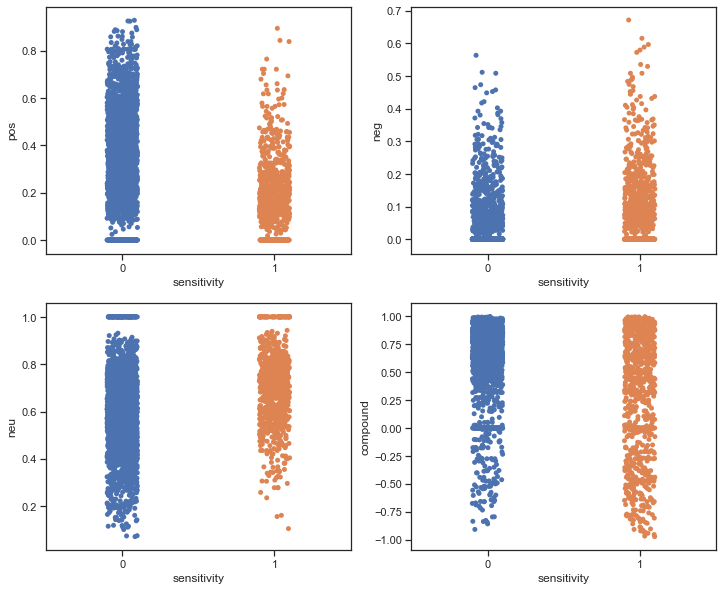

In [423]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
sns.set(style="ticks", color_codes=True)
sns.catplot(x="sensitivity", y="pos", data=train_data_polar, ax=ax[0][0]);
plt.close()
sns.catplot(x="sensitivity", y="neg", data=train_data_polar, ax=ax[0][1]);
plt.close()
sns.catplot(x="sensitivity", y="neu", data=train_data_polar, ax=ax[1][0]);
plt.close()
sns.catplot(x="sensitivity", y="compound", data=train_data_polar, ax=ax[1][1]);
plt.close()

### Join SVD & vectorized data with Polarized data and apply ML models

In [265]:
train_data_svd = pd.DataFrame(X_train_noisefree)

In [292]:
train_data_svd_polar = pd.DataFrame()
train_data_svd_polar = pd.concat([train_data_svd,X_polar,train_data['sensitivity']], axis=1)

In [293]:
train_data_svd_polar.head()

,0,1,2,3,4,5,6,7,8,9,...,4264,4265,4266,4267,4268,neg,neu,pos,compound,sensitivity
0,0.001479,0.002107,-0.000288,0.009265,-0.003338,0.000543,0.002709,-0.002859,0.002122,-0.001389,...,0.016386,-0.000430,0.002062,-0.000300,-0.000960,0.000,0.758,0.242,0.9270,1
1,-0.000223,-0.000306,-0.000167,0.001991,0.003295,-0.001289,-0.001412,-0.000318,-0.000472,-0.000446,...,0.002482,-0.000314,-0.000415,-0.001041,-0.001913,0.000,0.455,0.545,0.9180,0
2,-0.000096,0.002377,-0.000663,-0.002319,0.001577,-0.000230,-0.000066,0.010988,0.000781,-0.000217,...,-0.000205,-0.000372,-0.000298,0.003077,0.000674,0.000,0.656,0.344,0.2732,0
3,0.002274,-0.002463,-0.004012,0.001477,0.001174,0.000559,-0.004369,-0.013480,-0.000843,0.002954,...,-0.000581,-0.001890,0.002950,-0.000594,0.001533,0.073,0.733,0.194,0.6467,1
4,-0.000886,-0.002266,-0.000755,-0.002790,-0.000402,-0.000785,-0.006966,0.002332,0.000530,0.000123,...,-0.009694,-0.000958,0.001505,-0.005462,-0.005525,0.084,0.589,0.327,0.8034,0


In [276]:
X_svd_polar = train_data_svd_polar.iloc[:,:-1]
y_svd_polar = train_data_svd_polar.sensitivity
X_svd_polar_train, X_svd_polar_test, y_svd_polar_train, y_svd_polar_test = train_test_split(X_svd_polar, y_svd_polar, test_size=0.4, random_state = 1234)

#### Logistic Regression on SVD & polarized data

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy 0.8333333333333334
Confusion matrix:
[[797  74]
 [126 203]]
Accuracy: 0.8333333333333334
Precision:  0.7328519855595668
Recall:  0.6170212765957447
F1 Score:  0.66996699669967
Average precision-recall score: 0.56


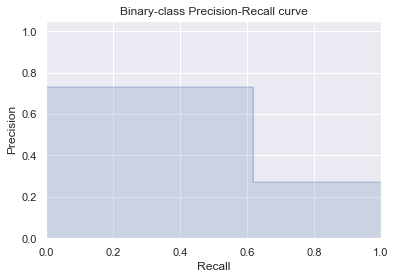

In [277]:
logreg = LogisticRegression()
logreg = logreg.fit(X_svd_polar_train, y_svd_polar_train)
y_pred = logreg.predict(X_svd_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_svd_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_svd_polar_test, y_pred))
calculate_outcome(y_svd_polar_test, y_pred)

#### Logistic Regression CV on SVD & polarized data

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


accuracy 0.8333333333333334
Confusion matrix:
[[784  87]
 [113 216]]
Accuracy: 0.8333333333333334
Precision:  0.7128712871287128
Recall:  0.6565349544072948
F1 Score:  0.6835443037974683
Average precision-recall score: 0.56


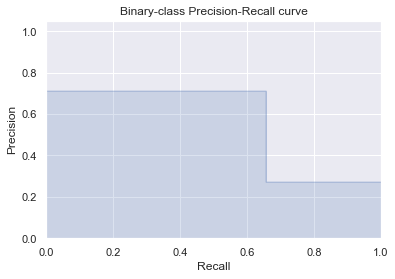

In [278]:
logreg = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
logreg = logreg.fit(X_svd_polar_train, y_svd_polar_train)
y_pred = logreg.predict(X_svd_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_svd_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_svd_polar_test, y_pred))
calculate_outcome(y_svd_polar_test, y_pred)

#### Find polarity from test data and predict on the above model

In [267]:
sid = SentimentIntensityAnalyzer()
test_data = pd.read_csv("C:\\Users\\MANOJ\\Desktop\\Insofe\\PHD\\code\\test.csv", sep=',', header=0, na_values='unknown')
test_data_polar=pd.DataFrame()
for review in test_data['review']:
    ss = sid.polarity_scores(review)
    temp_df=pd.DataFrame(ss, index=range(1))
    test_data_polar=test_data_polar.append(temp_df,ignore_index=True)

In [287]:
test_data_svd_polar = pd.concat([test_data_svd,test_data_polar], axis=1)

In [288]:
test_pred = logreg.predict(test_data_svd_polar)

In [290]:
np.bincount(test_pred)

array([953, 247], dtype=int64)

In [291]:
pd.DataFrame(test_pred).to_csv("test_result_logregcv_svd_polar.csv")

#### Grid search on Logistic Regression

accuracy 0.8266666666666667
Confusion matrix:
[[778  93]
 [115 214]]
Accuracy: 0.8266666666666667
Precision:  0.6970684039087948
Recall:  0.6504559270516718
F1 Score:  0.6729559748427674
Average precision-recall score: 0.55


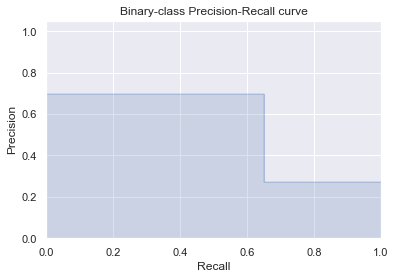

In [306]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv=3)
logreg_cv.fit(X_svd_polar_train, y_svd_polar_train)
y_pred = logreg_cv.predict(X_svd_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_svd_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_svd_polar_test, y_pred))
calculate_outcome(y_svd_polar_test, y_pred)

In [311]:
train_data_svd_polar.shape

(3000, 4274)

#### Smote on SVD & polarized data and predict results

In [318]:
smote = SMOTE(random_state=0)

X_smote,y_smote=smote.fit_sample(X_svd_polar_train,y_svd_polar_train)

X_train_smote = pd.DataFrame(data=X_smote)
y_train_smote= pd.DataFrame(data=y_smote,columns=['sensitivity'])

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy 0.81
Confusion matrix:
[[702 169]
 [ 59 270]]
Accuracy: 0.81
Precision:  0.6150341685649203
Recall:  0.8206686930091185
F1 Score:  0.703125
Average precision-recall score: 0.55


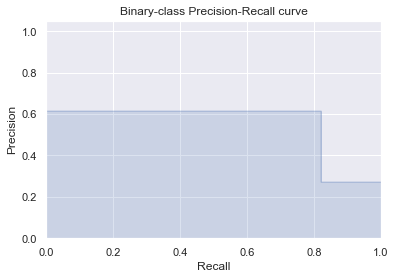

In [335]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train_smote, y_smote)
y_pred = logreg.predict(X_svd_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_svd_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_svd_polar_test, y_pred))
calculate_outcome(y_svd_polar_test, y_pred)

accuracy 0.8225
Confusion matrix:
[[729 142]
 [ 71 258]]
Accuracy: 0.8225
Precision:  0.645
Recall:  0.78419452887538
F1 Score:  0.7078189300411524
Average precision-recall score: 0.56


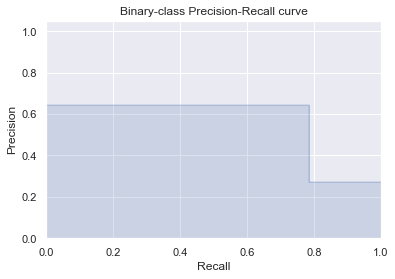

In [336]:
logreg = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial',max_iter=2000)
logreg.fit(X_train_smote, y_smote)
y_pred = logreg.predict(X_svd_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_svd_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_svd_polar_test, y_pred))
calculate_outcome(y_svd_polar_test, y_pred)

In [337]:
test_pred = logreg.predict(test_data_svd_polar)
pd.DataFrame(test_pred).to_csv("test_result_logreg_svd_polar_smote.csv")

In [338]:
np.bincount(test_pred)

array([862, 338], dtype=int64)

#### Apply ngrams and minimum document frequency on tfidf vector to reduce dimension

In [158]:
# This function removes unpopular words, applies svd and then passes to the model
def fit_model2(model):
    nb = Pipeline([('vect', TfidfVectorizer(min_df=0.0025,ngram_range=(1,2))),
                   ('svd' , TruncatedSVD(n_components=500, n_iter=7, random_state=1234)),
                   ('clf', model),
                  ])
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    test_pred = nb.predict(test_data['lemmatized_review'])
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    calculate_outcome(y_test, y_pred)
    return test_pred

Confusion matrix:
[[799  72]
 [131 198]]
Accuracy: 0.8308333333333333
Precision:  0.7333333333333333
Recall:  0.601823708206687
F1 Score:  0.66110183639399
Average precision-recall score: 0.55


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

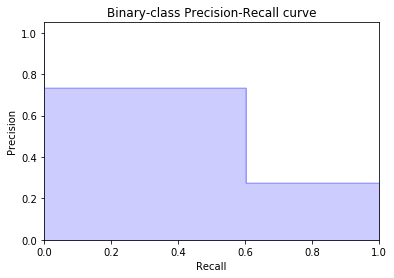

In [159]:
fit_model2(LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial',max_iter=2000))

### Do SVD on reduced tfidf vector, add polarized data to it, do smote and then apply ML models

In [207]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.0025,ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_review'])
U, Sigma, VT = randomized_svd(tfidf, n_components=500)
X_train_noisefree = np.dot(U,np.diag(Sigma))
X_train_noisefree = np.dot(X_train_noisefree, VT)
train_data_svd = pd.DataFrame(X_train_noisefree)
train_data_svd_polar = pd.concat([train_data_svd,train_data_polar],axis=1)
train_data_svd_polar['sensitivity'] = train_data.sensitivity

In [208]:
train_data_svd_polar.shape

(3000, 1027)

In [209]:
train_data_svd_polar.head()

,0,1,2,3,4,5,6,7,8,9,...,1017,1018,1019,1020,1021,neg,neu,pos,compound,sensitivity
0,-0.003347,-0.000744,-0.010780,-0.001092,-0.012128,0.004033,0.003317,-0.000007,-0.001458,0.001127,...,0.004189,-0.002564,-0.001203,-0.001213,0.017809,0.000,0.758,0.242,0.9270,1
1,-0.002401,-0.001550,-0.004659,-0.005076,0.006092,0.004258,-0.000718,-0.000786,-0.010615,-0.003198,...,-0.002099,-0.014366,-0.000172,-0.002998,0.009763,0.000,0.455,0.545,0.9180,0
2,0.003862,0.020455,-0.006058,-0.008934,-0.006872,0.003025,0.001716,-0.001523,0.004652,-0.001132,...,0.001126,-0.006062,0.001743,0.000458,-0.007708,0.000,0.656,0.344,0.2732,0
3,-0.003891,-0.002252,0.010478,0.016136,-0.000107,-0.012778,0.000968,0.006065,-0.004550,0.001116,...,0.003149,0.017691,-0.006929,-0.010121,0.011962,0.073,0.733,0.194,0.6467,1
4,-0.000407,0.006430,0.019709,-0.012974,0.004111,-0.007096,-0.003470,-0.010473,0.003377,0.001913,...,0.003977,-0.012516,-0.008036,-0.005141,0.000286,0.084,0.589,0.327,0.8034,0


In [211]:
X_svd_polar = train_data_svd_polar.iloc[:,:-1]
y_svd_polar = train_data_svd_polar.sensitivity
X_svd_polar_train, X_svd_polar_test, y_svd_polar_train, y_svd_polar_test = train_test_split(X_svd_polar, y_svd_polar, test_size=0.4, random_state = 1234)

In [216]:
smote = SMOTE(random_state=0)

X_smote,y_smote=smote.fit_sample(X_svd_polar_train,y_svd_polar_train)

X_train_smote = pd.DataFrame(data=X_smote)

In [217]:
X_train_smote.shape

(2598, 1026)

accuracy 0.8216666666666667
Confusion matrix:
[[727 144]
 [ 70 259]]
Accuracy: 0.8216666666666667
Precision:  0.6426799007444168
Recall:  0.7872340425531915
F1 Score:  0.7076502732240436
Average precision-recall score: 0.56


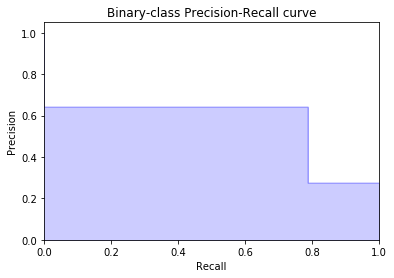

In [218]:
logreg = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial',max_iter=2000)
logreg.fit(X_train_smote, y_smote)
y_pred = logreg.predict(X_svd_polar_test)
print('accuracy %s' % accuracy_score(y_pred, y_svd_polar_test))
print('Confusion matrix:')
print(confusion_matrix(y_svd_polar_test, y_pred))
calculate_outcome(y_svd_polar_test, y_pred)

In [ ]:
test_pred = logreg.predict(test_data_svd_polar)
pd.DataFrame(test_pred).to_csv("test_result_logreg_svd_polar_smote.csv")

### Add polar data to GoogleNews vector and predict

In [341]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['lemmatized_review']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)

X_train_word_average = pd.DataFrame(X_train_word_average)
X_train_word_average = pd.concat([X_train_word_average,train_data_polar],axis=1)
X_train_word_average['sensitivity'] = train_data.sensitivity

X = X_train_word_average.iloc[:,:-1]
y = X_train_word_average.sensitivity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 1234)

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
W0828 06:35:03.283045  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['ahhhhhhh', 'savenyahhhhh', 'drebii', 'baraboooooooo']
W0828 06:35:03.307011  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['ahhhhhhh', 'savenyahhhhhh']
W0828 06:35:03.333908  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['encanto', 'pumba', 'timón']


accuracy 0.84
Confusion matrix:
[[790  81]
 [111 218]]
Accuracy: 0.84
Precision:  0.7290969899665551
Recall:  0.662613981762918
F1 Score:  0.694267515923567
Average precision-recall score: 0.58


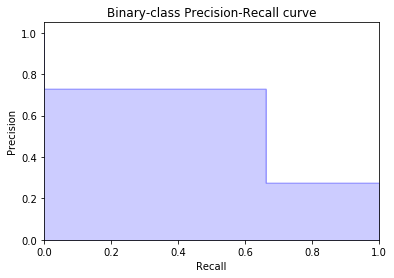

In [342]:
logreg = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial',max_iter=2000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

### Add polar data to GoogleNews vector, do Smote and predict

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
W0828 07:09:12.524402  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['ahhhhhhh', 'savenyahhhhh', 'drebii', 'baraboooooooo']
W0828 07:09:12.552326  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['ahhhhhhh', 'savenyahhhhhh']
W0828 07:09:12.592221  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['encanto', 'pumba', 'timón']


accuracy 0.8433333333333334
Confusion matrix:
[[190  29]
 [ 18  63]]
Accuracy: 0.8433333333333334
Precision:  0.6847826086956522
Recall:  0.7777777777777778
F1 Score:  0.7283236994219653
Average precision-recall score: 0.59


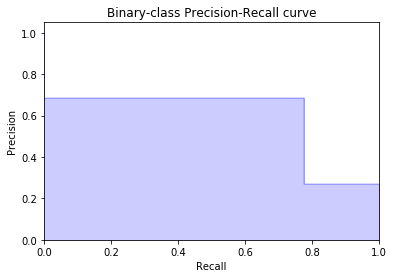

In [359]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['lemmatized_review']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)

X_train_word_average = pd.DataFrame(X_train_word_average)
X_train_word_average = pd.concat([X_train_word_average,train_data_polar],axis=1)
X_train_word_average['sensitivity'] = train_data.sensitivity

X = X_train_word_average.iloc[:,:-1]
y = X_train_word_average.sensitivity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 1234)
smote = SMOTE(random_state=0)
X_smote,y_smote=smote.fit_sample(X_train,y_train)
X_train_smote = pd.DataFrame(data=X_smote)

logreg = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial',max_iter=2000)
logreg.fit(X_train_smote, y_smote)
y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

In [360]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['lemmatized_review']), axis=1).values

X_test_word_average = word_averaging_list(wv,test_tokenized)

X_test_word_average = pd.DataFrame(X_test_word_average)
X_test_word_average = pd.concat([X_test_word_average,test_data_polar],axis=1)

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
W0828 07:13:19.047387  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input []


In [364]:
test_pred = logreg.predict(X_test_word_average)
pd.DataFrame(test_pred).to_csv("test_result_word2vec_logreg.csv")

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
W0828 07:07:37.852224  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['ahhhhhhh', 'savenyahhhhh', 'drebii', 'baraboooooooo']
W0828 07:07:37.870176  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['ahhhhhhh', 'savenyahhhhhh']
W0828 07:07:37.901097  3116 <ipython-input-323-06092af1ab2b>:12] cannot compute similarity with no input ['encanto', 'pumba', 'timón']


accuracy 0.84
Confusion matrix:
[[790  81]
 [111 218]]
Accuracy: 0.84
Precision:  0.7290969899665551
Recall:  0.662613981762918
F1 Score:  0.694267515923567
Average precision-recall score: 0.58


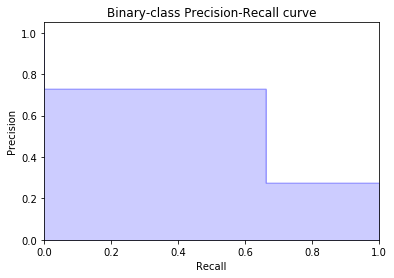

In [356]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['lemmatized_review']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)

X_train_word_average = pd.DataFrame(X_train_word_average)
X_train_word_average = pd.concat([X_train_word_average,train_data_polar],axis=1)
X_train_word_average['sensitivity'] = train_data.sensitivity

X = X_train_word_average.iloc[:,:-1]
y = X_train_word_average.sensitivity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 1234)

logreg = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial',max_iter=2000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

### Simple Deep neural network on above trained GoogleNews, polarized, smote vector

In [501]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 1234)

Epoch 1/10
 - 8s - loss: 0.4855 - acc: 0.7611
Epoch 2/10
 - 5s - loss: 0.3962 - acc: 0.8078
Epoch 3/10
 - 5s - loss: 0.3821 - acc: 0.8244
Epoch 4/10
 - 5s - loss: 0.3648 - acc: 0.8361
Epoch 5/10
 - 5s - loss: 0.3459 - acc: 0.8456
Epoch 6/10
 - 5s - loss: 0.3437 - acc: 0.8472
Epoch 7/10
 - 5s - loss: 0.3180 - acc: 0.8644
Epoch 8/10
 - 5s - loss: 0.3073 - acc: 0.8672
Epoch 9/10
 - 5s - loss: 0.2964 - acc: 0.8656
Epoch 10/10
 - 5s - loss: 0.2741 - acc: 0.8828
Confusion matrix:
[[735 136]
 [ 77 252]]
Accuracy: 0.8225
Precision:  0.6494845360824743
Recall:  0.7659574468085106
F1 Score:  0.702928870292887
Average precision-recall score: 0.56


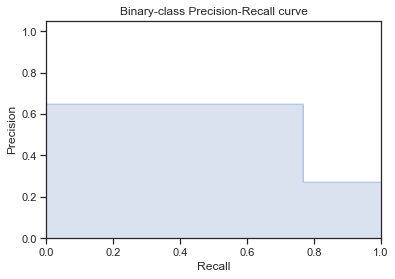

In [598]:
model = Sequential()
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
                  validation_data=(X_test, y_test),
                  )
model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=10, batch_size=32, verbose=2)

y_pred = model.predict_classes(X_test.to_numpy())
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

### Use GoogleNews vector instead of Glove and predict using RNN and RCNN methods

In [647]:
embeddings_index_2 = {}

In [649]:
for word in wv.vocab:
    embeddings_index_2[word] = wv.vectors_norm[wv.vocab['all'].index]

In [650]:
len(embeddings_index_2)

3000000

### RNN

In [655]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=300, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    gru_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(gru_node)
    for i in range(0,hidden_layer):
        model.add(GRU(gru_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
    model.add(GRU(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [656]:
model_RNN = Build_Model_RNN_Text(word_index,embeddings_index_2, 2)
model_RNN.summary()
model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=2)
y_pred = model_RNN.predict_classes(X_test_Glove)
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

32
Train on 1800 samples, validate on 1200 samples
Epoch 1/10
 - 56s - loss: 0.6066 - acc: 0.7006 - val_loss: 0.5734 - val_acc: 0.7258
Epoch 2/10
 - 39s - loss: 0.5615 - acc: 0.7217 - val_loss: 0.5518 - val_acc: 0.7258
Epoch 3/10
 - 37s - loss: 0.5392 - acc: 0.7378 - val_loss: 0.5314 - val_acc: 0.7567
Epoch 4/10
 - 37s - loss: 0.4672 - acc: 0.8200 - val_loss: 0.4680 - val_acc: 0.7875
Epoch 5/10
 - 38s - loss: 0.3350 - acc: 0.8700 - val_loss: 0.5360 - val_acc: 0.7925
Epoch 6/10
 - 39s - loss: 0.2670 - acc: 0.9006 - val_loss: 0.5244 - val_acc: 0.7917
Epoch 7/10
 - 45s - loss: 0.2018 - acc: 0.9278 - val_loss: 0.5717 - val_acc: 0.8025
Epoch 8/10
 - 41s - loss: 0.1696 - acc: 0.9389 - val_loss: 0.6625 - val_acc: 0.7950
Epoch 9/10
 - 37s - loss: 0.1401 - acc: 0.9517 - val_loss: 0.6510 - val_acc: 0.7925
Epoch 10/10
 - 39s - loss: 0.1188 - acc: 0.9583 - val_loss: 0.7637 - val_acc: 0.7933


### RCNN

In [661]:
def Build_Model_RCNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=300):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [662]:
model_RCNN = Build_Model_RCNN_Text(word_index,embeddings_index_2, 2)
model_RCNN.summary()
model_RCNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=2)
y_pred = model_RCNN.predict_classes(X_test_Glove)
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
calculate_outcome(y_test, y_pred)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          1287600   
_________________________________________________________________
dropout_122 (Dropout)        (None, 500, 300)          0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 499, 256)          153856    
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 249, 256)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 248, 256)          131328    
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 124, 256)          0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 124, 256)          525312    
__________

KeyboardInterrupt: 

# Clustering

In [20]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_review'])
vectorized_train_data = pd.DataFrame(tfidf.toarray(), columns= tfidf_vectorizer.get_feature_names())

In [21]:
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=1234)

In [22]:
svd.fit(vectorized_train_data)

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=7,
             random_state=1234, tol=0.0)

In [23]:
review_svd = svd.transform(vectorized_train_data)

In [24]:
review_svd.shape

(3000, 500)

In [26]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(review_svd)

In [27]:
kmeans.labels_

array([0, 1, 0, ..., 0, 0, 0])

In [65]:
review_clusters = pd.DataFrame({'sensitivity': train_data.sensitivity, 'cluster': kmeans.labels_}, columns=['sensitivity','cluster'])

In [66]:
review_clusters.shape

(3000, 2)

In [67]:
review_clusters.head()

,sensitivity,cluster
0,1,0
1,0,1
2,0,0
3,1,0
4,0,0


###  Pearson’s Chi-Squared test

In [106]:
table = pd.crosstab(
    review_clusters['cluster'],
    review_clusters['sensitivity'],
    margins = False
)

In [107]:
table

sensitivity,0,1
cluster,,
0,1776,826
1,394,4


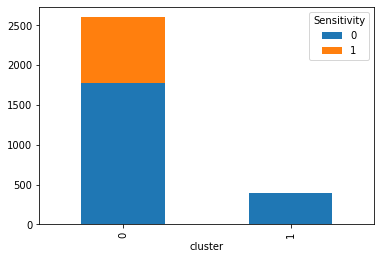

In [108]:
table.plot.bar(stacked=True)
plt.legend(title='Sensitivity')
plt.show()

In [109]:
stat, p, dof, expected = chi2_contingency(table)
print('Chi2 Stat: ',stat)
print("Degrees of Freedom: ",dof)
print("P-Value: ",p)
print("Contingency Table:")
print(expected)
# interpret test-statistic
prob = 0.99
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

#If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
#If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.
if abs(stat) >= critical:
    print('===> Dependent (reject H0)')
else:
    print('===> Independent (fail to reject H0)')

alpha = 1.0 - prob

#If p-value <= alpha: significant result, reject null hypothesis (H0), dependent.
#If p-value > alpha: not significant result, fail to reject null hypothesis (H0), independent.
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('===> Dependent (reject H0)')
else:
    print('===> Independent (fail to reject H0)')

Chi2 Stat:  161.4630208088722
Degrees of Freedom:  1
P-Value:  5.420067834814979e-37
Contingency Table:
[[1882.11333333  719.88666667]
 [ 287.88666667  110.11333333]]
probability=0.990, critical=6.635, stat=161.463
===> Dependent (reject H0)
significance=0.010, p=0.000
===> Dependent (reject H0)


### Outcomes: